##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 改成抓三號管的資料進來
1. 先跟雲端做連結
2. 檢查格式
3. 整理資料形狀


In [ ]:
from google.colab import drive
root = '/content/drive/'
drive.mount(root)

Mounted at /content/drive/


In [ ]:
## 這是抓第一批5min間隔的資料
# pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/林園管歷史資料擷取.csv",encoding="ANSI")
pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/林園管歷史資料擷取.csv",encoding="utf-8")
pipe3 = pipe3.drop(0) # 去除missing data
# pipe3 = pipe3.drop("Unnamed: 113", axis = 1)
print(pipe3.shape)
# pipe3.head()
pipe3.describe(include = "all").transpose()

(2303, 36)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,2303,2303,2022/4/7 00:05,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLY_USI_03_FI_BC,2303.0,NaN,NaN,NaN,0.388515,2.369656,-14.237984,-1.137796,0.357233,1.974995,8.213395
FI-254-1.PV,2303.0,NaN,NaN,NaN,18218.901941,408.398825,15919.32715,18051.26367,18281.95703,18470.54785,19703.91992
中+亞,2303.0,NaN,NaN,NaN,18198.842367,567.370506,15988.05202,17853.681035,18165.07806,18556.502155,19885.66861
台變化率,2303.0,NaN,NaN,NaN,0.000074,0.013047,-0.064099,-0.007586,-0.000064,0.007106,0.089227
中+亞變化率,2303.0,NaN,NaN,NaN,0.000151,0.016687,-0.076681,-0.01062,0.000396,0.010877,0.092215
台移動平均(20min),2301.0,NaN,NaN,NaN,18219.138835,375.50078,16015.53101,18063.83545,18283.29639,18450.78955,19251.23877
移動平均流量偏差,2301.0,NaN,NaN,NaN,0.390036,2.146761,-12.621112,-1.013164,0.257343,1.778038,7.509945
Unnamed: 8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time.1,2279,2279,2022/4/21 00:05,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## 這是第一批+第二批5min資料
# pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/林園管歷史資料擷取.csv",encoding="ANSI")
pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/pipe3_5min.csv",encoding="utf-8")
pipe3 = pipe3.drop(0) # 去除missing data
# pipe3 = pipe3.drop("Unnamed: 113", axis = 1)
print(pipe3.shape)
# pipe3.head()
pipe3.describe(include = "all").transpose()

(2591, 71)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,2303,2303,2022/4/7 00:05,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLY_USI_03_FI_BC,2303.0,NaN,NaN,NaN,0.388515,2.369656,-14.237984,-1.137796,0.357233,1.974995,8.213395
FI-254-1.PV,2303.0,NaN,NaN,NaN,18218.901941,408.398825,15919.32715,18051.26367,18281.95703,18470.54785,19703.91992
中+亞,2303.0,NaN,NaN,NaN,18198.842367,567.370506,15988.05202,17853.681035,18165.07806,18556.502155,19885.66861
台變化率,2303.0,NaN,NaN,NaN,0.000074,0.013047,-0.064099,-0.007586,-0.000064,0.007106,0.089227
...,...,...,...,...,...,...,...,...,...,...,...
CLY_USI_03_FI_BC.9,2591.0,NaN,NaN,NaN,-0.342316,3.809378,-33.547493,-2.204925,-0.281587,1.575433,26.630278
FI-254-1.PV.9,2591.0,NaN,NaN,NaN,17782.623644,931.225034,14718.4082,16973.350585,18015.17969,18478.60547,19778.24609
中+亞.9,2591.0,NaN,NaN,NaN,17639.76111,1013.393655,13394.59198,16877.51004,17808.27316,18353.941835,21596.1365
台變化率.9,2591.0,NaN,NaN,NaN,0.000081,0.012884,-0.07013,-0.006656,0.0003,0.006987,0.100367


In [ ]:
## 這是抓1min資料
# pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/林園管歷史資料擷取.csv",encoding="ANSI")
pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/pipe3_1min.csv",encoding="utf-8")
pipe3 = pipe3.drop(0) # 去除missing data
# pipe3 = pipe3.drop("Unnamed: 113", axis = 1)
print(pipe3.shape)
# pipe3.head()
pipe3.describe(include = "all").transpose()

(5758, 49)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,1438,1438,2021/8/18 00:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLY_USI_03_FI_BC,1438.0,NaN,NaN,NaN,-0.509961,3.137588,-17.292027,-2.232041,-0.536289,1.19465,9.198226
FI-254-1.PV,1438.0,NaN,NaN,NaN,17377.760536,338.95963,16427.69727,17147.87061,17392.725585,17620.897458,18170.12109
中+亞,1438.0,NaN,NaN,NaN,17203.901275,553.288104,15179.77192,16843.921632,17190.811735,17517.38474,19082.95748
Unnamed: 4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time.1,1438,1438,2021/8/23 00:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLY_USI_03_FI_BC.1,1438.0,NaN,NaN,NaN,-0.517134,3.371431,-13.779897,-2.200337,-0.417813,1.37214,8.572825
FI-254-1.PV.1,1438.0,NaN,NaN,NaN,17036.86773,417.739119,15625.12109,16787.727055,17039.353515,17256.411135,18893.33594
中+亞.1,1438.0,NaN,NaN,NaN,16860.113144,451.902991,14973.70915,16609.52143,16883.32139,17124.97213,18097.82534
Unnamed: 9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['Time', 'CLY_USI_03_FI_BC', 'FI-254-1.PV', '中+亞', '台變化率', '中+亞變化率'], dtype='object')
Index(['CLY_USI_03_FI_BC', 'FI-254-1.PV', '中+亞', '台變化率', '中+亞變化率'], dtype='object')
(2298, 5)
(2298, 5)
(2274, 5)
(2274, 5)
(2286, 5)
(2286, 5)
(1722, 5)
(1722, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2298, 5)
(2586, 5)
(2586, 5)


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35722 missing from current font.
  font.set_text

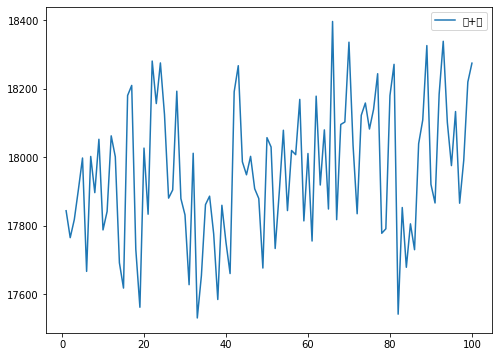

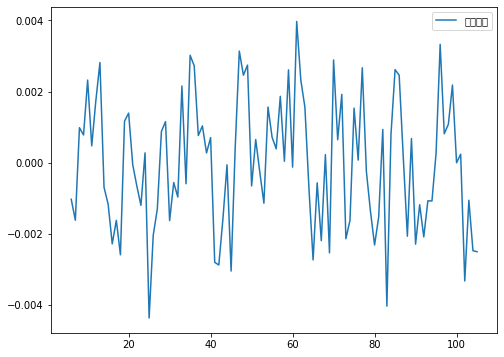

In [ ]:
## 這邊是抓5min資料用的
#先把全部資料一組一組放進list中
all_df = [pipe3.iloc[:,0:6].copy(), pipe3.iloc[:,9:15].copy(), pipe3.iloc[:,16:22].copy(), pipe3.iloc[:,23:29].copy(), pipe3.iloc[:,30:36].copy(), 
          pipe3.iloc[:,37:43].copy(),pipe3.iloc[:,44:50].copy(),pipe3.iloc[:,51:57].copy(),pipe3.iloc[:,58:64].copy(),pipe3.iloc[:,65:71].copy(),]

for i, part_df in enumerate(all_df):
  part_df = part_df.dropna() # 去除missing data

  if i == 0:
    part_df[[part_df.columns[3],]].head(100).plot() ## 把沒移動平均的值畫出來
    print(part_df.columns)

  part_df = part_df.rolling(6).mean() ## 做移動平均，rolling(n)，做n筆移動平均，如果不做移動平均，直接把這行mark掉
  part_df = part_df.dropna()  ## 做完移動平均後，前n個值因為沒辦法做移動平均，所以要drop掉，如果不做移動平均，把這行跟上面那行一起mark掉
  
  if i == 0:
    part_df[[part_df.columns[3],]].head(100).plot() ## 把移動平均後的值畫出來比較看看
    print(part_df.columns) ## 印出來比較一下，發現time的column不見了

  all_df[i] = part_df
  
  ## 下面兩行是印出來確認，是不是真的有放進去，如果形狀一樣表示成功
  print(part_df.shape)
  print(all_df[i].shape)


Index(['Time', 'CLY_USI_03_FI_BC', 'FI-254-1.PV', '中+亞'], dtype='object')
Index(['CLY_USI_03_FI_BC', 'FI-254-1.PV', '中+亞'], dtype='object')
(1438, 3)
(1438, 3)
(1438, 3)
(1438, 3)
(5758, 3)
(5758, 3)
(5758, 3)
(5758, 3)
(5758, 3)
(5758, 3)
(5758, 3)
(5758, 3)
(1438, 3)
(1438, 3)
(5758, 3)
(5758, 3)
(5694, 3)
(5694, 3)
(5758, 3)
(5758, 3)


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


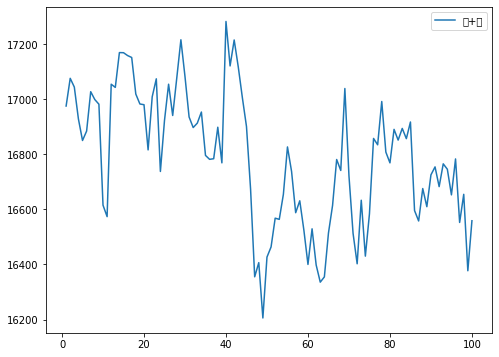

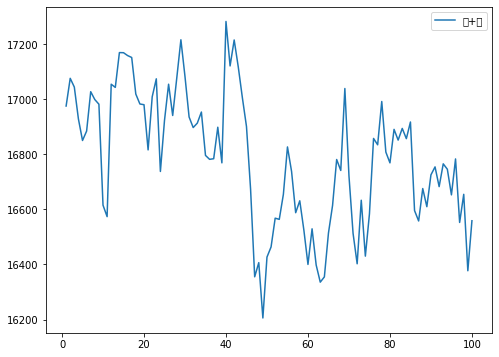

In [ ]:
## 這邊是抓1min資料用的
#先把全部資料一組一組放進list中
all_df = [pipe3.iloc[:,0:4].copy(), pipe3.iloc[:,5:9].copy(), pipe3.iloc[:,10:14].copy(), pipe3.iloc[:,15:19].copy(), pipe3.iloc[:,20:24].copy(), 
          pipe3.iloc[:,25:29].copy(),pipe3.iloc[:,30:34].copy(),pipe3.iloc[:,35:39].copy(),pipe3.iloc[:,40:44].copy(),pipe3.iloc[:,45:49].copy(),]

do_norm = False ## False表示沒做正規化，用於後面要做inverse_transform時判斷用

for i, part_df in enumerate(all_df):
  part_df = part_df.dropna() # 去除missing data

  if i == 0:
    part_df[[part_df.columns[3],]].head(100).plot() ## 把沒移動平均的值畫出來
    print(part_df.columns)

  part_df = part_df.rolling(1).mean() ## 做移動平均，rolling(n)，做n筆移動平均，如果不做移動平均，n可以設定為1
  part_df = part_df.dropna()  ## 做完移動平均後，前n個值因為沒辦法做移動平均，所以要drop掉，如果不做移動平均，把這行跟上面那行一起mark掉
  
  if i == 0:
    part_df[[part_df.columns[2],]].head(100).plot() ## 把移動平均後的值畫出來比較看看
    print(part_df.columns) ## 印出來比較一下，發現time的column不見了

  all_df[i] = part_df
  
  ## 下面兩行是印出來確認，是不是真的有放進去，如果形狀一樣表示成功
  print(part_df.shape)
  print(all_df[i].shape)


In [ ]:
# 這格是測試把時間從字串轉乘datetime格式，試試看有沒有轉成功，如果可以再來用pop把時間pop出來，不然pop完後就時間就不見了
print(f"datetime轉換前格式: {type(all_df[0].iloc[0,0])}")
date_time = pd.to_datetime(all_df[0].iloc[:,0])
print(f"datetime轉換後格式: {type(date_time.iloc[0])}")

datetime轉換前格式: <class 'numpy.float64'>
datetime轉換後格式: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
## 做移動平均時，會自動把時間欄給去掉，所以就不用執行這格，不用特地把時間那欄拿出來，
#把list中的每一組資料的時間都pop出來，並放到一個date_time的清單中，並且印出來看看是不是成功，如果成功feature應該會從6變成5
time_list = []
for part_df in all_df:
  date_time = pd.to_datetime(part_df.pop(part_df.columns[0])) # 把每一組資料的時間都，pop出來後
  time_list.append(date_time)
  print(f"把時間pop出來後的矩陣形狀: {part_df.shape}, pop出來後的時間形狀: {date_time.shape}" )
# all_df[1].drop(0)

把時間pop出來後的矩陣形狀: (2298, 4), pop出來後的時間形狀: (2298,)
把時間pop出來後的矩陣形狀: (2274, 4), pop出來後的時間形狀: (2274,)
把時間pop出來後的矩陣形狀: (2286, 4), pop出來後的時間形狀: (2286,)
把時間pop出來後的矩陣形狀: (1722, 4), pop出來後的時間形狀: (1722,)
把時間pop出來後的矩陣形狀: (2298, 4), pop出來後的時間形狀: (2298,)
把時間pop出來後的矩陣形狀: (2298, 4), pop出來後的時間形狀: (2298,)
把時間pop出來後的矩陣形狀: (2298, 4), pop出來後的時間形狀: (2298,)
把時間pop出來後的矩陣形狀: (2298, 4), pop出來後的時間形狀: (2298,)
把時間pop出來後的矩陣形狀: (2298, 4), pop出來後的時間形狀: (2298,)
把時間pop出來後的矩陣形狀: (2586, 4), pop出來後的時間形狀: (2586,)


In [ ]:
type(time_list[0].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
## 如果前面沒有把時間那欄pop出來，並且轉成timedate格式，這格就會跳錯誤，告訴你不能放float格式的資料進來
# 把時間轉成以秒計算
for i, date_time in enumerate(time_list):
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  time_list[i] = timestamp_s
  print(time_list[i].iloc[10]) # 每組時間資料的第6筆數據，確認看看是否有真的轉成秒數

TypeError: ignored

In [ ]:
## 這格是把資料集裡面原本5個特徵，只抽出來源端與接收端流量，其他可能干擾先拿掉
for i in range(len(all_df)):
  all_df[i] = all_df[i].iloc[:,1:3]
  print(all_df[i].shape)
  print(all_df[i].columns)

(1438, 2)
Index(['FI-254-1.PV', '中+亞'], dtype='object')
(1438, 2)
Index(['FI-254-1.PV.1', '中+亞.1'], dtype='object')
(5758, 2)
Index(['FI-254-1.PV.2', '中+亞.2'], dtype='object')
(5758, 2)
Index(['FI-254-1.PV.3', '中+亞.3'], dtype='object')
(5758, 2)
Index(['FI-254-1.PV.4', '中+亞.4'], dtype='object')
(5758, 2)
Index(['FI-254-1.PV.5', '中+亞.5'], dtype='object')
(1438, 2)
Index(['FI-254-1.PV.6', '中+亞.6'], dtype='object')
(5758, 2)
Index(['FI-254-1.PV.7', '中+亞.7'], dtype='object')
(5694, 2)
Index(['FI-254-1.PV.8', '中+亞.8'], dtype='object')
(5758, 2)
Index(['FI-254-1.PV.9', '中+亞.9'], dtype='object')


## 這邊開始把資料拆成train,validation,test拆分比例為(70%,20%,10%)，並做正規化

In [ ]:
train_df = []
val_df = []
test_df = []

column_indices = {name: i for i, name in enumerate(all_df[0].columns)} # 把每個feature給編號，在這裡因為每組資料的feature都一樣，所以不用特別每個都存下來，直接抓第一組資料當代表就可以了

for i, part_df in enumerate(all_df):

  n = len(part_df)
  train_df.append(part_df[0:int(n*0.7)])
  val_df.append(part_df[int(n*0.7):int(n*0.9)])
  test_df.append(part_df[int(n*0.9):])

num_features = all_df[0].shape[1] # 這裡也是一樣，每一組資料的feature是一樣多的，所以一個就可以了，不用每一個都算一次，再一個個放到list中

In [ ]:
train_df[0]

,FI-254-1.PV,中+亞
1,17116.69922,16975.83146
2,17129.79688,17076.54764
3,17122.71875,17044.82192
4,17170.28125,16928.96297
5,17275.20117,16850.59736
...,...,...
1002,17367.96680,17535.34400
1003,17523.66992,17523.91882
1004,17296.90430,17344.72152
1005,17368.99609,17452.05646


In [ ]:
print(len(train_df),len(val_df),len(test_df)) # 看一下是否每個都是5組(擴大為10組)資料
print(len(train_df[0]),len(val_df[0]),len(test_df[0])) # 看一下是否有按照7:2:1的比例分好

10 10 10
1006 288 144


In [ ]:
## 把column name都改成跟第0組一樣，方便等等把切分成windows後的資料串接起來
for i in range(len(train_df)):
  train_df[i].columns = train_df[0].columns
  val_df[i].columns = val_df[0].columns
  test_df[i].columns = test_df[0].columns
  print(f"\n第{i+1}組column name")
  print("train data columns: ", train_df[i].columns)
  print("val  data columns: ", val_df[i].columns)
  print("test data columns: ", val_df[i].columns)


第1組column name
train data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
val  data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
test data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第2組column name
train data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
val  data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
test data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第3組column name
train data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
val  data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
test data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第4組column name
train data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
val  data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
test data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第5組column name
train data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')
val  data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='

In [ ]:
# Feature Scaling，做minmaxscaler正規化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
columns = train_df[0].columns ## 做完minmaxscaler後會變成numpy格式，columns會不見，所以等等轉回DataFrame格式時要補上用的
for i in range(len(train_df)):
  train_df[i] = pd.DataFrame(sc.fit_transform(train_df[i]))
  train_df[i].columns = columns
  val_df[i] = pd.DataFrame(sc.fit_transform(val_df[i]))
  val_df[i].columns = columns
  test_df[i] = pd.DataFrame(sc.fit_transform(test_df[i]))
  test_df[i].columns = columns
do_norm = True ## 表示有正規化，用來等等判斷是否有做inverse_transform用

In [ ]:
# 這邊是做標準化
train_mean = []
train_std = []
for i in range(len(train_df)):
  train_mean.append(train_df[i].mean())
  train_std.append(train_df[i].std())

  train_df[i] = (train_df[i] - train_mean[i]) / train_std[i]
  val_df[i] = (val_df[i] - train_mean[i]) / train_std[i]
  test_df[i] = (test_df[i] - train_mean[i]) / train_std[i]

In [ ]:
train_df[0]

,FI-254-1.PV,中+亞
1,17116.69922,16975.83146
2,17129.79688,17076.54764
3,17122.71875,17044.82192
4,17170.28125,16928.96297
5,17275.20117,16850.59736
...,...,...
1002,17367.96680,17535.34400
1003,17523.66992,17523.91882
1004,17296.90430,17344.72152
1005,17368.99609,17452.05646


In [ ]:
train_mean[0]

NameError: ignored

In [ ]:
## 沒做正規化的話這邊會報錯，因為train_mean是在上面做正規化那格定義的，所以報錯不緊張，先看看自己有沒有做正規化

# 取一組資料來看看分布狀況如何，可以發現狀況應該挺差的，但先試試看，之後再回來改
df_std = (all_df[1] - train_mean[1]) / train_std[1]
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(all_df[1].keys(), rotation=90)

NameError: ignored

# 下面用原程式碼去修改代入的資料

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    # del self.column_indices[self.label_columns[0]]

    # Work out the window parameters.
    self.input_width = input_width # 給他學習資料的寬度，像是給他24小時預測往後6小時，這個就是前面24小時，如果一小時一筆，那就是24筆，就是24
    self.label_width = label_width  # 他要預測資料的寬度，像是給他24小時預測往後6小時，這個就是後面6小時，如果一小時一筆，那就是6筆，就是6
    self.shift = shift  # offset+label width是多少，像是現在是12點，我要預測6點到9點的資料，如此12點到6點中間就是offset，如果一小時一筆，那就是6筆，就是6，再加6點到9點，加3，總共就是9

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice] # total_window_size的width包含了input_width + shift，這裡是用slice的方式只取前面input_width的寬度

    self.label_start = self.total_window_size - self.label_width # 整個窗格的width往前倒推label width(要預測的時間長度)出來就是label開始的地方
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self): # 真貼心，連這些功能都寫好，可以直接呼叫出來看
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],
                     label_columns=['中+亞'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['中+亞']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],
                     label_columns=['中+亞'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['中+亞']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :] # 第2維的地方是timestep
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns], ## 這就是把label的值從資料中抓出來
        # [labels[:, :, self.label_columns[name]] for name in self.label_columns], ## 這就是把label的值從資料中抓出來
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window # 這行應該是把這個def並到WindowGenerator這個class裡面

Try it out:

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[0][:w2.total_window_size]),
                           np.array(train_df[0][100:100+w2.total_window_size]),
                           np.array(train_df[0][200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window) # 這邊要用剛剛的Window這個class，然後再.split_window才行

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 2)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

#### 下面這格有把plot補上如果有做正規化要inverse回來再畫圖

In [ ]:
def plot(self, model=None, plot_col='中+亞', max_subplots=3):

  # 下面等號上面整串是我改成如果有做正規化就inverse回來再畫圖
  if do_norm == True: # True表示有做正規化，前面正規化的cell有補上這格
    labels = np.zeros((self.example[1].shape[0],self.example[1].shape[1],self.example[0].shape[2])) # 這邊是先產生形狀正確的0矩陣，主要有兩個用意，一個是inverse時不能所有batch一次做，要一個個做做完再放進來，另一個原因是，不是所有column都有做預測值，所以不能直接用，要用正確形狀的矩陣，然後再把值填進來
    labels[:,0,:] = self.example[1][:,0,:] # 這邊就是有預測出來的值，補到剛剛0矩陣中，有種複製很多份的感覺放進去的感覺，這邊可以這麼做，因為最終會只取我們要的column出來
    inputs = np.zeros(self.example[0].shape) # 產生inputs的0矩陣，等等放inverse完的結果
    for i in range(self.example[0].shape[0]): # 這邊開始一個一個batch拿出來做inverse
      inverse_input = sc.inverse_transform(self.example[0][i]) # inputs做inverse
      inverse_labels = sc.inverse_transform(labels[i]) # labels做inverse
      print("labels", labels[:,0].shape)
      print("inverse_labels", inverse_labels.shape)
      inputs[i] = inverse_input # 前面的0矩陣開始替換
      labels[i,0] = inverse_labels # 前面的0矩陣開始替換
  else:
    inputs, labels = self.example # 這裡會直接呼叫下面有@property裝飾器過，.example的屬性，會直接拿train數據集的一個batch出來當example
  # =========================================================
  
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs)) # 預設最多就是畫三張出來看看，你也可以在max_subplots的參數設定最少畫幾張
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None) # 抓label_columns_indices.get這個dict中的plot_col這個key的value，如果沒有就回傳None
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue # 應該是這輪的每個特徵都畫完了，所以換下一輪再重新開始

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None: # 如果有把模型當參數丟進去的話，會直接利用模型做完預測後畫出預測值，沒有學習直接預測
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend() # 加圖例

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot # 把這個plot加到WindowGenerator這個class中

In [ ]:
#######這格式用來測試用的不用執行是沒關係的

# a = np.array([[[1.,2.]],[[4.,5.]],[[7.,8.]]])
# print(a[1,0])


a = np.zeros((w2.example[1].shape[0],w2.example[1].shape[1],w2.example[0].shape[2]))
print(a[:,0,0])
print(w2.example[1][:,0,0])
a[:,0,:] = w2.example[1][:,0,:]
print("a=",a)
print("inverse = ",sc.inverse_transform(w2.example[0][0]).shape)
labels = np.zeros((w2.example[1].shape[0],w2.example[1].shape[1],w2.example[0].shape[2]))
input = np.zeros(w2.example[0].shape)
for i in range(w2.example[0].shape[0]):
  inverse_input = sc.inverse_transform(w2.example[0][i])
  inverse_labels = sc.inverse_transform(a[i])
  input[i] = inverse_input
  labels[i,0] = inverse_labels
print("inputs = ",input)
print("prediction = ",labels)

  # 如果有正規化就修正回來，但目前好像格式上有問題，要再修正，目前看起來應該是預測的結果再作inverse才對
  if do_norm == True:
    labels = np.zeros((self.example[1].shape[0],self.example[1].shape[1],self.example[0].shape[2]))
    labels[:,0,:] = self.example[1][:,0,:]
    input = np.zeros(self.example[0].shape)
    for i in range(self.example[0].shape[0]):
      inverse_input = sc.inverse_transform(self.example[0][i]) # 如果有做正規化，就inverse回來
      inverse_labels = sc.inverse_transform(labels[i])
      input[i] = inverse_input
      labels[i,0] = inverse_labels
  else:
    inputs, labels = self.example # 這裡會直接呼叫下面有@property裝飾器過，.example的屬性，會直接拿train數據集的一個batch出來當example

IndentationError: ignored

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


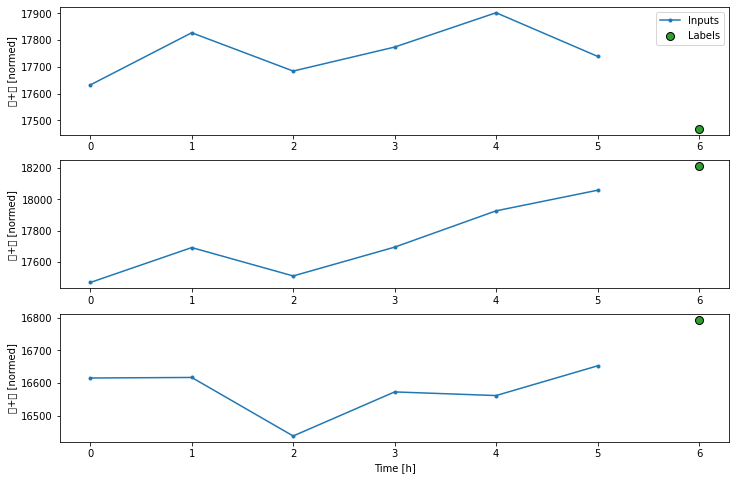

In [ ]:
w2.plot(plot_col='中+亞')

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

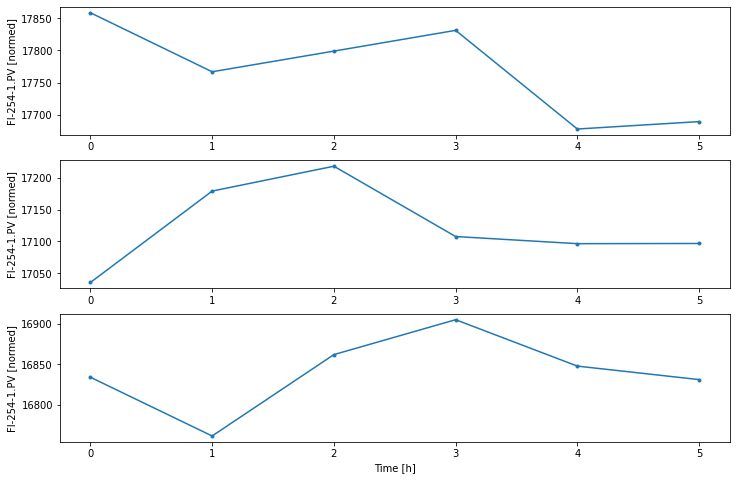

In [ ]:
w2.plot(plot_col='FI-254-1.PV')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

tf.keras.utils.timeseries_dataset_from_array這個做出來是個generator，這樣可以比較省記憶體，要用的時候再生成出來

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array( # 這邊可以參考deep learning with python第二版的第461頁，有詳細介紹
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window) # 跟剛剛拆分出來的結果去做對應

  return ds

WindowGenerator.make_dataset = make_dataset # 在把make_dataset並到WindowGenerator這個class裡面

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [ ]:
## 用這個@property裝飾器的方式，就可以確保這些數據只能被get沒辦法被set
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None) # 找WindowGenerator這個class中的'_example'這個屬性值是多少，如果沒有這個屬性值，則回傳None
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train)) # 這邊會在執行一次上面train這個@property裝飾過的method，所以會直接把train_df給抓進來
    # And cache it for next time
    self._example = result
  return result

## 把上面四個裝飾器都併入WindowGenerator這個class中
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# ## 用這個@property裝飾器的方式，就可以確保這些數據只能被get沒辦法被set
# def concat_train(self):
#   try:
#     self.concat_train = self.concat_train.concatenate(self.make_dataset(self.train_df))
#     print("資料串接成功")
#   except NameError:
#     self.concat_train = self.make_dataset(self.train_df)
#     print("沒有串接到資料")
#   return self.concat_train

# @property
# def val(self):
#   return self.make_dataset(self.val_df)

# @property
# def test(self):
#   return self.make_dataset(self.test_df)

# @property
# def example(self):
#   """Get and cache an example batch of `inputs, labels` for plotting."""
#   result = getattr(self, '_example', None) # 找WindowGenerator這個class中的'_example'這個屬性值是多少，如果沒有這個屬性值，則回傳None
#   if result is None:
#     # No example batch was found, so get one from the `.train` dataset
#     result = next(iter(self.train)) # 這邊會在執行一次上面train這個@property裝飾過的method，所以會直接把train_df給抓進來
#     # And cache it for next time
#     self._example = result
#   return result

# ## 把上面四個裝飾器都併入WindowGenerator這個class中
# WindowGenerator.concat_train = concat_train
# WindowGenerator.val = val
# WindowGenerator.test = test
# WindowGenerator.example = example

# 2022/10/26 修改下面這格程式碼，把dataset串起來，這件事試圖寫成函數

- 2022/10/31 燒腦後發現有點難，還沒想到怎麼改寫成函式
- 2022/11/02 再次燒腦後確認應該沒辦法，主要原因為每跑一次迴圈，class就會重新建構一次，所以不可能在不同class架構下跑出串再一起的東西。除非用global variable，但這又會造成不小心再多執行一次就串接到重覆資料的風險，所以不建議

In [ ]:

# all_train = None
# all_val = None
# all_test = None
for i in range(len(train_df)):
  single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df[i], val_df=val_df[i], test_df=test_df[i],
    label_columns=['中+亞'])
  
  if i == 0:
    all_train = single_step_window.train
    all_val = single_step_window.val
    all_test = single_step_window.test
  else:
    all_train = all_train.concatenate(single_step_window.train)
    all_val = all_val.concatenate(single_step_window.val)
    all_test = all_test.concatenate(single_step_window.test)

all_train = all_train.cache().shuffle(10000)
all_val = all_val.cache().shuffle(10000)
all_test = all_test.cache().shuffle(10000)


Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec # timeseries_dataset_from_array有用這個方法，裡面應該有element_spec這個屬性

(TensorSpec(shape=(None, 6, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],
    label_columns=['中+亞'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['中+亞']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 2)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['中+亞'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                #  metrics=[tf.keras.metrics.MeanAbsoluteError()])
                  metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]) # 用MAPE當旗標
                      
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

9/9 [==============================] - 0s 2ms/step - loss: 37152.0312 - mean_absolute_percentage_error: 0.7587


In [ ]:
val_performance['Baseline']

[37152.03125, 0.7586862444877625]

That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],
    label_columns=['中+亞'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['中+亞']

In [ ]:
## 合併wide_window資料集
wide_window_train = None
wide_window_val = None
wide_window_test = None
for i in range(len(train_df)):
  wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df[i], val_df=val_df[i], test_df=test_df[i],
    label_columns=['中+亞'])
  
  if i == 0:
    wide_window_train = wide_window.train
    wide_window_val = wide_window.val
    wide_window_test = wide_window.test
  else:
    wide_window_train = wide_window_train.concatenate(wide_window.train)
    wide_window_val = wide_window_val.concatenate(wide_window.val)
    wide_window_test = wide_window_test.concatenate(wide_window.test)

wide_window_train = wide_window_train.cache().shuffle(10000)
wide_window_val = wide_window_val.cache().shuffle(10000)
wide_window_test = wide_window_test.cache().shuffle(10000)


This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


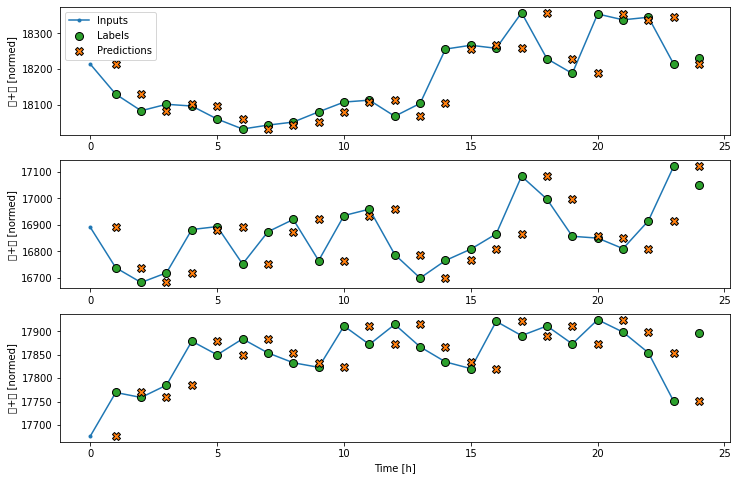

In [ ]:
wide_window.plot(baseline, plot_col='中+亞')

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 2)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

因為會訓練很多model，會重複使用到compile與fit所以，直接打包起來，等等方便使用

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2, train=None, val=None):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # 監控的值是validation的loss
                                                    patience=patience, # 容忍多少個epochs沒改善
                                                    mode='min') # 目標是要找最大還是最小，最大通常是設定給acc，最小是設定給loss，建議不要使用auto

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
  # model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                # metrics=[tf.keras.metrics.MeanAbsoluteError()])
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()]) # 用MAPE當旗標
  if train is None and val is None:
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
  else:
    history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [ ]:
## 單純只用一組資料集

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window) # 不要忘記還有patience可以調整

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
32/32 [==============================] - 1s 10ms/step - loss: 34629.7539 - mean_absolute_percentage_error: 201.2529 - mean_absolute_error: 34629.7539 - val_loss: 33803.9375 - val_mean_absolute_percentage_error: 197.9408 - val_mean_absolute_error: 33803.9375
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 33524.1875 - mean_absolute_percentage_error: 194.8256 - mean_absolute_error: 33524.1875 - val_loss: 32702.6055 - val_mean_absolute_percentage_error: 191.4908 - val_mean_absolute_error: 32702.6055
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 32418.4453 - mean_absolute_percentage_error: 188.3967 - mean_absolute_error: 32418.4453 - val_loss: 31601.1426 - val_mean_absolute_percentage_error: 185.0401 - val_mean_absolute_error: 31601.1426
Epoch 4/20
32/32 [==============================] - 0s 7ms/step - loss: 31312.7598 - mean_absolute_percentage_error: 181.9712 - mean_absolute_error: 31312.7598 - val_loss: 30499.9551 - val_mean_a

In [ ]:
## 用合併過的資料集

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window, train=all_train, val=all_val) # 不要忘記還有patience可以調整

val_performance['Linear'] = linear.evaluate(all_val)
performance['Linear'] = linear.evaluate(all_test, verbose=0)

Epoch 1/20
977/977 [==============================] - 4s 3ms/step - loss: 45506464.0000 - mean_absolute_percentage_error: 31.2131 - mean_absolute_error: 5097.3477 - val_loss: 164312.8750 - val_mean_absolute_percentage_error: 2.2234 - val_mean_absolute_error: 365.6784
Epoch 2/20
977/977 [==============================] - 3s 3ms/step - loss: 43645.9492 - mean_absolute_percentage_error: 0.9833 - mean_absolute_error: 157.1603 - val_loss: 35163.1953 - val_mean_absolute_percentage_error: 0.8538 - val_mean_absolute_error: 135.4055
Epoch 3/20
977/977 [==============================] - 3s 3ms/step - loss: 33901.7969 - mean_absolute_percentage_error: 0.8548 - mean_absolute_error: 136.1188 - val_loss: 35077.5312 - val_mean_absolute_percentage_error: 0.8533 - val_mean_absolute_error: 135.2974
Epoch 4/20
977/977 [==============================] - 3s 3ms/step - loss: 33807.9492 - mean_absolute_percentage_error: 0.8536 - mean_absolute_error: 135.9283 - val_loss: 34953.4297 - val_mean_absolute_percent

In [ ]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['中+亞']

#### 驗算一下linear model的MAPE，太大了很奇怪
mape = 100 * mean(abs((y_true - y_pred) / y_true), axis=-1)



In [ ]:
## 用predict先抓出預測值
prediction_linear = linear.predict(single_step_window.val)
prediction_linear = prediction_linear.flatten()

9/9 [==============================] - 0s 2ms/step


In [ ]:
## 看看有幾筆預測值
prediction_linear.shape

(287,)

In [ ]:
## 抓出target
target = None
for i in range(len(single_step_window.val)):
  a = next(iter(single_step_window.val))
  a = np.array(a[1]).reshape(-1,)
  if i == 0:
    target = a
  else:
    target = np.concatenate((target,a), axis=None)

In [ ]:
## 看看有幾筆target
target.shape

(288,)

In [ ]:
target[target < 1]

array([], dtype=float32)

In [ ]:
## 抓出來算算看，看起來應該不會到好幾萬阿
ape_3upper = 0
total_ape = 0
for i in range(prediction_linear.shape[0]):
  ape = (np.absolute(target[i] - prediction_linear[i]))/target[i] * 100
  total_ape = total_ape + ape
  if ape > 3:
    ape_3upper = ape_3upper + 1
mape = total_ape/prediction_linear.shape
print("mape(%) =", mape)
print(ape_3upper)

mape(%) = [2.17850729]
81


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


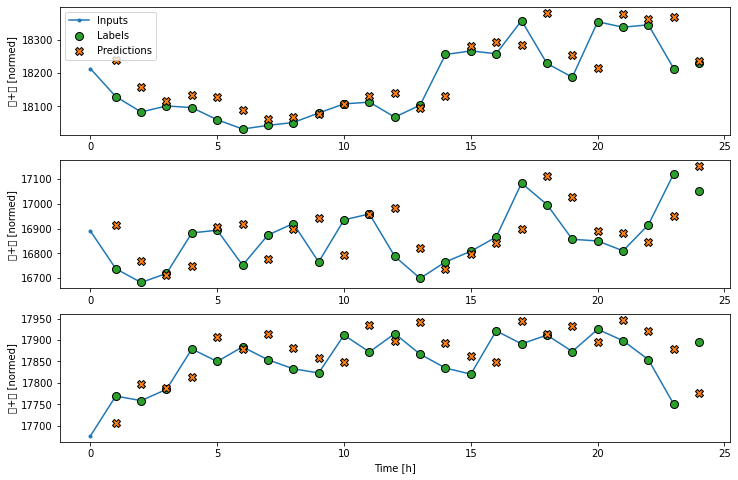

In [ ]:
wide_window.plot(linear, plot_col='中+亞')

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

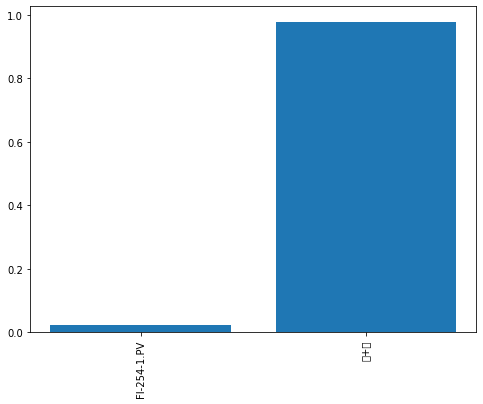

In [ ]:
plt.bar(x = range(len(train_df[0].columns)),
        height=linear.layers[0].kernel[:,0].numpy()) # 把kernel的權重抓出來，並當成bar的高度
axis = plt.gca()
axis.set_xticks(range(len(train_df[0].columns)))
_ = axis.set_xticklabels(train_df[0].columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [ ]:
## 只用一組資料集
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window, patience=5)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
32/32 [==============================] - 1s 12ms/step - loss: 84392048.0000 - mean_absolute_percentage_error: 43.8096 - val_loss: 435691.8125 - val_mean_absolute_percentage_error: 3.7555
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 1257564.1250 - mean_absolute_percentage_error: 5.6046 - val_loss: 108540.0859 - val_mean_absolute_percentage_error: 1.5882
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 121570.1094 - mean_absolute_percentage_error: 1.6361 - val_loss: 56490.6680 - val_mean_absolute_percentage_error: 1.0653
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 57408.3594 - mean_absolute_percentage_error: 1.0478 - val_loss: 38264.6680 - val_mean_absolute_percentage_error: 0.8055
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 55761.0820 - mean_absolute_percentage_error: 1.0361 - val_loss: 37874.5586 - val_mean_absolute_percentage_error: 0.7993
Epoch 6/20
32/32 [============

In [ ]:
## 用合併後的資料集
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window, train=all_train, val=all_val, patience=5)

val_performance['Dense'] = dense.evaluate(all_val)
performance['Dense'] = dense.evaluate(all_test, verbose=0)

Epoch 1/20
977/977 [==============================] - 5s 4ms/step - loss: 1353807.2500 - mean_absolute_percentage_error: 1.8812 - val_loss: 23319.9023 - val_mean_absolute_percentage_error: 0.6926
Epoch 2/20
977/977 [==============================] - 4s 4ms/step - loss: 23090.6133 - mean_absolute_percentage_error: 0.7040 - val_loss: 22680.1250 - val_mean_absolute_percentage_error: 0.6841
Epoch 3/20
977/977 [==============================] - 4s 4ms/step - loss: 24075.3145 - mean_absolute_percentage_error: 0.7232 - val_loss: 22643.5195 - val_mean_absolute_percentage_error: 0.6846
Epoch 4/20
977/977 [==============================] - 4s 4ms/step - loss: 27018.3047 - mean_absolute_percentage_error: 0.7742 - val_loss: 36629.9688 - val_mean_absolute_percentage_error: 0.9544
Epoch 5/20
977/977 [==============================] - 4s 4ms/step - loss: 27508.3574 - mean_absolute_percentage_error: 0.7825 - val_loss: 35654.8008 - val_mean_absolute_percentage_error: 0.9392
Epoch 6/20
977/977 [========

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
CONV_WIDTH = 10
conv_window = WindowGenerator( # 這裡沒有對參數train_df做設定，預設就會抓被命名為train_df的數據集進來，所以可以一開始就把train dataset直接命名為train_df，這樣就可以直接不用額外設定train_df這個參數
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],
    label_columns=['中+亞'])

conv_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['中+亞']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


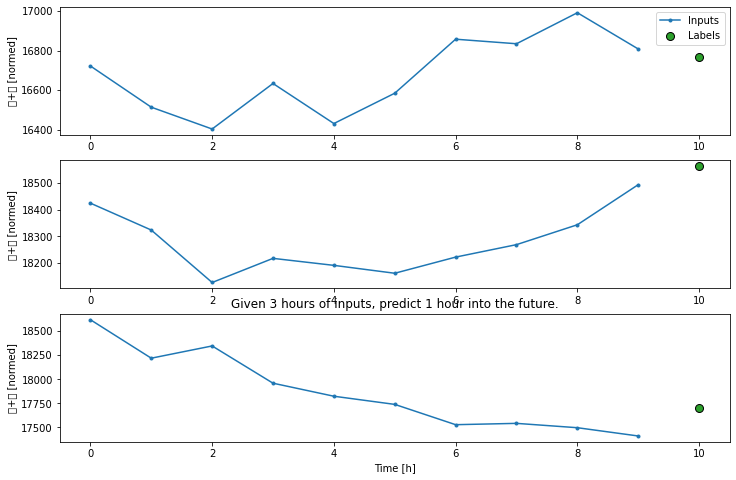

In [ ]:
conv_window.plot(plot_col='中+亞')
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [ ]:
## conv_window資料集合併，1min資料的WIDTH要開大一點
CONV_WIDTH = 40
conv_window_train = None
conv_window_val = None
conv_window_test = None
for i in range(len(train_df)):
  conv_window = WindowGenerator( # 這裡沒有對參數train_df做設定，預設就會抓被命名為train_df的數據集進來，所以可以一開始就把train dataset直接命名為train_df，這樣就可以直接不用額外設定train_df這個參數
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df[i], val_df=val_df[i], test_df=test_df[i],
    label_columns=['中+亞'])
  
  if i == 0:
    conv_window_train = conv_window.train
    conv_window_val = conv_window.val
    conv_window_test = conv_window.test
  else:
    conv_window_train = conv_window_train.concatenate(conv_window.train)
    conv_window_val = conv_window_val.concatenate(conv_window.val)
    conv_window_test = conv_window_test.concatenate(conv_window.test)

conv_window_train = conv_window_train.cache().shuffle(10000)
conv_window_val = conv_window_val.cache().shuffle(10000)
conv_window_test = conv_window_test.cache().shuffle(10000)


You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features) # 不會去動到batch這個dimension
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension. (只單純只是為了有time這個dimension而已，所以直接設1即可，當成一個timestamp就好)
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 40, 2)
Output shape: (32, 1, 1)


In [ ]:
## 這邊是指執行最後一組資料集的結果

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features) # 不會去動到batch這個dimension
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension. (只單純只是為了有time這個dimension而已，所以直接設1即可，當成一個timestamp就好)
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense, conv_window, patience=5)

# IPython.display.clear_output() # 這裡會清除輸出，所以只會顯示下面兩行運行的結果，trainning那些進度條都會被清掉
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
125/125 [==============================] - 1s 6ms/step - loss: 97407096.0000 - mean_absolute_percentage_error: 31.3653 - val_loss: 21816.7773 - val_mean_absolute_percentage_error: 0.5531
Epoch 2/20
125/125 [==============================] - 1s 5ms/step - loss: 63858.4023 - mean_absolute_percentage_error: 0.9212 - val_loss: 21798.2168 - val_mean_absolute_percentage_error: 0.5526
Epoch 3/20
125/125 [==============================] - 1s 5ms/step - loss: 63174.9570 - mean_absolute_percentage_error: 0.9112 - val_loss: 21710.5723 - val_mean_absolute_percentage_error: 0.5486
Epoch 4/20
125/125 [==============================] - 1s 6ms/step - loss: 63161.6953 - mean_absolute_percentage_error: 0.9161 - val_loss: 21708.0762 - val_mean_absolute_percentage_error: 0.5499
Epoch 5/20
125/125 [==============================] - 1s 5ms/step - loss: 62211.4375 - mean_absolute_percentage_error: 0.9060 - val_loss: 22790.4121 - val_mean_absolute_percentage_error: 0.5804
Epoch 6/20
125/125 [======

In [ ]:
## 這邊是指執行合併後資料集的結果

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features) # 不會去動到batch這個dimension
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension. (只單純只是為了有time這個dimension而已，所以直接設1即可，當成一個timestamp就好)
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense, conv_window, patience=8, train=conv_window_train, val=conv_window_val)

# IPython.display.clear_output() # 這裡會清除輸出，所以只會顯示下面兩行運行的結果，trainning那些進度條都會被清掉
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window_val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window_test, verbose=0)

Epoch 1/20
967/967 [==============================] - 6s 4ms/step - loss: 1665313.0000 - mean_absolute_percentage_error: 2.1783 - val_loss: 97810.5000 - val_mean_absolute_percentage_error: 1.1165
Epoch 2/20
967/967 [==============================] - 3s 3ms/step - loss: 61564.1680 - mean_absolute_percentage_error: 1.1069 - val_loss: 88653.9688 - val_mean_absolute_percentage_error: 1.0390
Epoch 3/20
967/967 [==============================] - 3s 3ms/step - loss: 58968.6562 - mean_absolute_percentage_error: 1.0882 - val_loss: 109738.8750 - val_mean_absolute_percentage_error: 1.4438
Epoch 4/20
967/967 [==============================] - 3s 3ms/step - loss: 60167.1602 - mean_absolute_percentage_error: 1.1280 - val_loss: 78099.8906 - val_mean_absolute_percentage_error: 1.0418
Epoch 5/20
967/967 [==============================] - 3s 3ms/step - loss: 67172.1797 - mean_absolute_percentage_error: 1.2101 - val_loss: 105369.3594 - val_mean_absolute_percentage_error: 1.5176
Epoch 6/20
967/967 [======

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


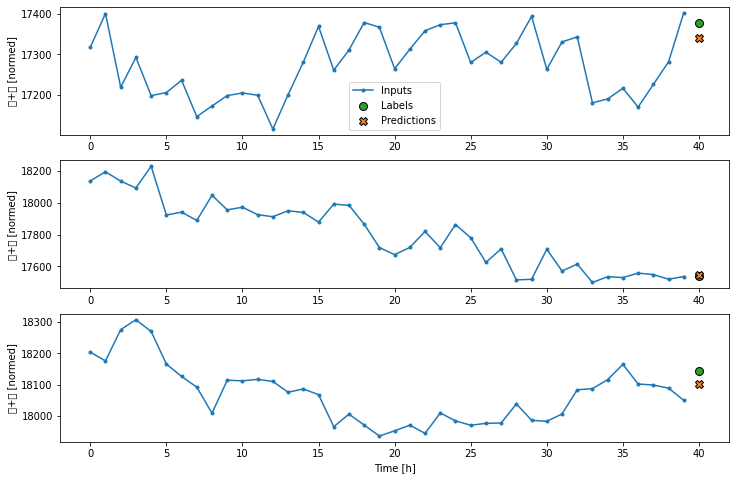

In [ ]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)  # 只能用在只有一個label的情況，這裡可以執行看看wide_window.example[1]，會發現有超過1個label
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 2)

ValueError:Exception encountered when calling layer "sequential_6" (type Sequential).

Input 0 of layer "dense_15" is incompatible with the layer: expected axis -1 of input shape to have value 80, but received input with shape (32, 48)

Call arguments received by layer "sequential_6" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 2), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
## 不需要不需要使用Flatten，所以也不用Reshape去把time的dimension弄出來
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    # tf.keras.layers.Conv1D(filters=32,
    #                        kernel_size=(CONV_WIDTH,), # 沒辦法在加層是因為上一層的conv1D出來後timestamp就只剩1了，如此kernel_size只要開大於1都會超過窗格，會跳錯誤
    #                        activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 40, 2)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
## 只做最後一組資料集

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                          #  kernel_size=(CONV_WIDTH,),
                           kernel_size=(3,), # 因為做1min的資料時，WIDTH放寬了，所以這邊改小，這樣就可以放超過一層了
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window, patience=5)

# IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
125/125 [==============================] - 7s 8ms/step - loss: 82713856.0000 - mean_absolute_percentage_error: 36.8329 - val_loss: 32619.9531 - val_mean_absolute_percentage_error: 0.6932
Epoch 2/20
125/125 [==============================] - 1s 8ms/step - loss: 93853.9844 - mean_absolute_percentage_error: 1.1179 - val_loss: 28994.7344 - val_mean_absolute_percentage_error: 0.6465
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 92422.4141 - mean_absolute_percentage_error: 1.0984 - val_loss: 28952.6758 - val_mean_absolute_percentage_error: 0.6461
Epoch 4/20
125/125 [==============================] - 1s 6ms/step - loss: 92363.2500 - mean_absolute_percentage_error: 1.0985 - val_loss: 29129.8027 - val_mean_absolute_percentage_error: 0.6450
Epoch 5/20
125/125 [==============================] - 1s 6ms/step - loss: 92455.9609 - mean_absolute_percentage_error: 1.0980 - val_loss: 28852.7852 - val_mean_absolute_percentage_error: 0.6443
Epoch 6/20
125/125 [======

In [ ]:
## 做合併後資料集

conv_model = tf.keras.Sequential([                     
    tf.keras.layers.Conv1D(filters=32,
                          #  kernel_size=(CONV_WIDTH,),
                           kernel_size=(10,), # 因為做1min的資料時，WIDTH放寬了，所以這邊改小，這樣就可以放超過一層了
                           padding='causal', # 試試看做zero padding效果如何，我猜causal padding應該會效果比較好
                           activation='relu'),                       
    tf.keras.layers.AveragePooling1D(pool_size=2,
                     ),
    tf.keras.layers.Conv1D(filters=64,
                          #  kernel_size=(CONV_WIDTH,),
                           kernel_size=(10,), # 因為做1min的資料時，WIDTH放寬了，所以這邊改小，這樣就可以放超過一層了
                           padding='causal', # 試試看做zero padding效果如何，我猜causal padding應該會效果比較好
                           activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2,
                     ),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Conv1D(filters=128,
                          #  kernel_size=(CONV_WIDTH,),
                           kernel_size=(10,), # 因為做1min的資料時，WIDTH放寬了，所以這邊改小，這樣就可以放超過一層了
                           padding='causal', # 試試看做zero padding效果如何，我猜causal padding應該會效果比較好
                           activation='relu'), 
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),

    
    # tf.keras.layers.Dense(units=1),
])



history = compile_and_fit(conv_model, conv_window, train=conv_window_train, val=conv_window_val, patience=20)

# IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window_val)
performance['Conv'] = conv_model.evaluate(conv_window_test, verbose=0)

Epoch 1/20
967/967 [==============================] - 12s 6ms/step - loss: 3000464.7500 - mean_absolute_error: 507.6552 - val_loss: 183049.5469 - val_mean_absolute_error: 299.3899
Epoch 2/20
967/967 [==============================] - 6s 6ms/step - loss: 131472.6875 - mean_absolute_error: 271.3926 - val_loss: 380875.0312 - val_mean_absolute_error: 529.2830
Epoch 3/20
967/967 [==============================] - 6s 6ms/step - loss: 151961.4531 - mean_absolute_error: 289.7695 - val_loss: 134753.9375 - val_mean_absolute_error: 224.0676
Epoch 4/20
967/967 [==============================] - 6s 6ms/step - loss: 148348.0781 - mean_absolute_error: 287.2725 - val_loss: 697752.1875 - val_mean_absolute_error: 761.1155
Epoch 5/20
967/967 [==============================] - 6s 6ms/step - loss: 187355.3906 - mean_absolute_error: 317.7258 - val_loss: 140057.1562 - val_mean_absolute_error: 232.0278
Epoch 6/20
967/967 [==============================] - 6s 6ms/step - loss: 122769.8984 - mean_absolute_error:

In [ ]:
conv_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 40, 32)            672       
                                                                 
 average_pooling1d (AverageP  (None, 20, 32)           0         
 ooling1D)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            20544     
                                                                 
 average_pooling1d_1 (Averag  (None, 10, 64)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 128)           82048     
                                                                 
 dense_20 (Dense)            (None, 10, 128)          

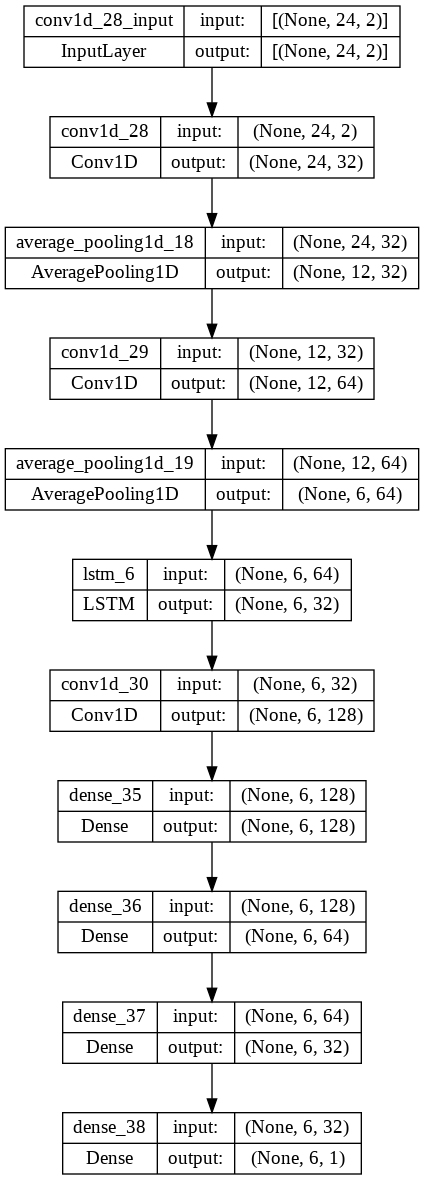

In [ ]:
tf.keras.utils.plot_model(conv_model, "ticket_classifier_with_shape_info.png", show_shapes=True)

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 2)
Labels shape: (32, 24, 1)
Output shape: (32, 6, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [ ]:
LABEL_WIDTH = 13
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1) # 因為這裡必須用[0,1,2]去預測[3]，所以為了符合必須得減1，如果不減1，label的長度是固定的，預測的結果卻多一個，會對不上，plot時會出問題
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],
    label_columns=['中+亞'])

wide_conv_window

Total window size: 53
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52]
Label column name(s): ['中+亞']

In [ ]:
## wide_conv_window資料集合併
LABEL_WIDTH = 13
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
CONV_WIDTH = 40
wide_conv_window_train = None
wide_conv_window_val = None
wide_conv_window_test = None
for i in range(len(train_df)):
  wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df[i], val_df=val_df[i], test_df=test_df[i],
    label_columns=['中+亞'])
  
  if i == 0:
    wide_conv_window_train = wide_conv_window.train
    wide_conv_window_val = wide_conv_window.val
    wide_conv_window_test = wide_conv_window.test
  else:
    wide_conv_window_train = wide_conv_window_train.concatenate(wide_conv_window.train)
    wide_conv_window_val = wide_conv_window_val.concatenate(wide_conv_window.val)
    wide_conv_window_test = wide_conv_window_test.concatenate(wide_conv_window.test)

wide_conv_window_train = wide_conv_window_train.cache().shuffle(10000)
wide_conv_window_val = wide_conv_window_val.cache().shuffle(10000)
wide_conv_window_test = wide_conv_window_test.cache().shuffle(10000)


In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 52, 2)
Labels shape: (32, 13, 1)
Output shape: (32, 13, 1)


In [ ]:
## 跟原本未合併前的資料集比對一下，其實就是上一格
for i in wide_conv_window_train:
  print("Wide conv window concatnation")
  print('Input shape:', i[0].shape)
  print('Labels shape:', i[1].shape)
  print('Output shape:', conv_model(i[0]).shape) 
  break

Wide conv window concatnation
Input shape: (32, 52, 2)
Labels shape: (32, 13, 1)
Output shape: (32, 13, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


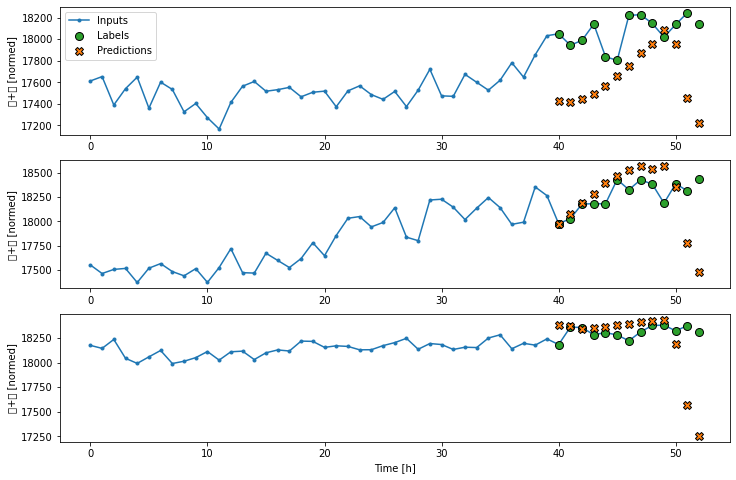

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


In [ ]:
## 只做一組資料
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window, patience=5)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
126/126 [==============================] - 3s 11ms/step - loss: 316936288.0000 - mean_absolute_error: 17783.0312 - val_loss: 295735104.0000 - val_mean_absolute_error: 17193.7344
Epoch 2/20
126/126 [==============================] - 1s 9ms/step - loss: 316897056.0000 - mean_absolute_error: 17781.9297 - val_loss: 295700128.0000 - val_mean_absolute_error: 17192.7168
Epoch 3/20
126/126 [==============================] - 1s 7ms/step - loss: 316860928.0000 - mean_absolute_error: 17780.9160 - val_loss: 295665216.0000 - val_mean_absolute_error: 17191.6992
Epoch 4/20
126/126 [==============================] - 1s 9ms/step - loss: 316825088.0000 - mean_absolute_error: 17779.9062 - val_loss: 295630528.0000 - val_mean_absolute_error: 17190.6914
Epoch 5/20
126/126 [==============================] - 1s 9ms/step - loss: 316789024.0000 - mean_absolute_error: 17778.8945 - val_loss: 295595712.0000 - val_mean_absolute_error: 17189.6797
Epoch 6/20
126/126 [==============================] - 1s 9m

In [ ]:
## 直接試試看用剛剛的wide_conv_window資料做做看，要記得把return_sequences=True拿掉

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32), 
    # tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_conv_window, patience=5, train=wide_conv_window_train, val=wide_conv_window_val)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_conv_window_val)
performance['LSTM'] = lstm_model.evaluate(wide_conv_window_test, verbose=0)

Epoch 1/20
236/236 [==============================] - 4s 8ms/step - loss: 258577264.0000 - mean_absolute_error: 15883.3428 - val_loss: 275023648.0000 - val_mean_absolute_error: 16532.7207
Epoch 2/20
236/236 [==============================] - 1s 5ms/step - loss: 258512544.0000 - mean_absolute_error: 15881.3086 - val_loss: 274959392.0000 - val_mean_absolute_error: 16530.7793
Epoch 3/20
236/236 [==============================] - 1s 5ms/step - loss: 258451072.0000 - mean_absolute_error: 15879.3613 - val_loss: 274895488.0000 - val_mean_absolute_error: 16528.8457
Epoch 4/20
236/236 [==============================] - 1s 5ms/step - loss: 258389456.0000 - mean_absolute_error: 15877.4277 - val_loss: 274831584.0000 - val_mean_absolute_error: 16526.9082
Epoch 5/20
236/236 [==============================] - 1s 5ms/step - loss: 258328128.0000 - mean_absolute_error: 15875.5039 - val_loss: 274767360.0000 - val_mean_absolute_error: 16524.9727
Epoch 6/20
236/236 [==============================] - 1s 5ms

In [ ]:
## 用wide_window合併後的資料集做做看

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window, train=wide_window_train, val=wide_window_val, patience=20)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window_val)
performance['LSTM'] = lstm_model.evaluate(wide_window_test, verbose=0)

Epoch 1/20
973/973 [==============================] - 10s 6ms/step - loss: 271638176.0000 - mean_absolute_error: 16316.2334 - val_loss: 281968544.0000 - val_mean_absolute_error: 16602.2461
Epoch 2/20
973/973 [==============================] - 5s 5ms/step - loss: 271370336.0000 - mean_absolute_error: 16308.0264 - val_loss: 281702784.0000 - val_mean_absolute_error: 16594.2461
Epoch 3/20
973/973 [==============================] - 5s 5ms/step - loss: 271110400.0000 - mean_absolute_error: 16300.0566 - val_loss: 281439296.0000 - val_mean_absolute_error: 16586.2988
Epoch 4/20
973/973 [==============================] - 5s 5ms/step - loss: 270851680.0000 - mean_absolute_error: 16292.1006 - val_loss: 281176352.0000 - val_mean_absolute_error: 16578.3574
Epoch 5/20
973/973 [==============================] - 5s 5ms/step - loss: 270594048.0000 - mean_absolute_error: 16284.1709 - val_loss: 280913216.0000 - val_mean_absolute_error: 16570.4375
Epoch 6/20
973/973 [==============================] - 5s 5m

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


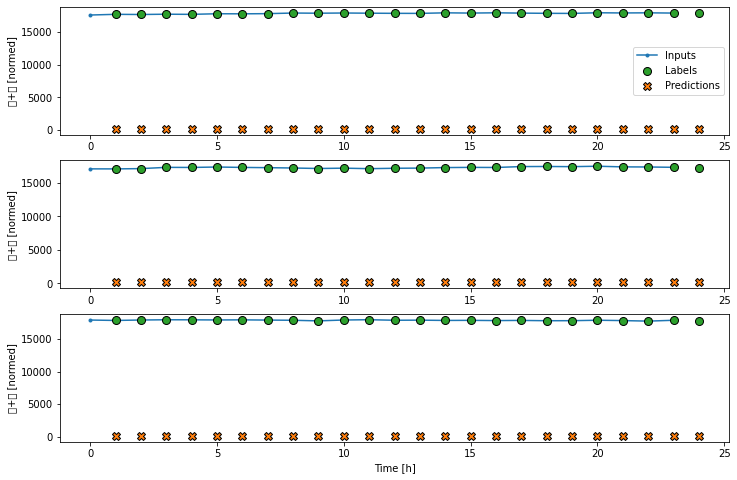

In [ ]:
wide_window.plot(lstm_model)

###往下幾個區塊是用來測試說為什麼lstm會完全無法收斂
- 方式是我分別用conv1d的模型與lstm的模型然後輸出來看看
- 也試過把conv1d後的結果丟到lstm的模型中，如果是直接return_sequences=False的方式輸出還是沒辦法收斂
- 如果再加上residual的方式，把剛剛的conv1d的結果一起加進來後，再放到只有一個neuron的dense layer，整個效果就提上來了
- 目前還是不知道為什麼

In [ ]:
## 這個cell分別用conv1d的模型與lstm的模型然後輸出來看看

from tensorflow.keras import layers
from tensorflow.keras.models import Model

## conv_part
model_input = layers.Input(shape=(24, 2), name="conv_part")  ## 不用把batch那個axis給放進去，他會自己補None
conv_1_output = layers.Conv1D(filters=32,kernel_size=(3,),activation='relu',padding = "same")(model_input)
dens_1_output = layers.Dense(units=24, activation='relu')(conv_1_output)
dens_2_output = layers.Dense(units=1)(conv_1_output)
conv_part_model = Model(inputs=model_input, outputs=dens_2_output)

## lstm_part
LSTM_1_output = layers.LSTM(24, return_sequences=False)(dens_1_output)
lstm_part_model = Model(inputs=model_input, outputs=LSTM_1_output)

## residual_lstm_part
LSTM_res_output = layers.LSTM(24, return_sequences=True)(dens_1_output)
Lstm_add_output = layers.add([LSTM_res_output, dens_1_output])
dens_lstm_res_output = layers.Dense(units=1)(Lstm_add_output)
residual_lstm_part_model = Model(inputs=model_input, outputs=dens_lstm_res_output)

In [ ]:
## 減少lstm cell看看是不是因為太多neuron導致梯度消失的問題
model_input = layers.Input(shape=(24, 2), name="lstm_less_part")  ## 不用把batch那個axis給放進去，他會自己補None
LSTM_less_output = layers.LSTM(3, return_sequences=False)(model_input)
lstm_less_model = Model(inputs=model_input, outputs=LSTM_less_output)


In [ ]:
history = compile_and_fit(lstm_less_model, wide_window, train=wide_window_train, val=wide_window_val)

Epoch 1/20


ValueError: ignored

In [ ]:
import tensorflow.keras as keras
import datetime
from tensorboard.plugins.hparams import api as hp

# res_LSTM_model = res_LSTM_model() ## 如果用def的方式來寫model就要先實體化出來才有compile或fit等方法

## conv_part區塊
conv_part_model.compile(
    optimizer='adam',
    loss='MeanSquaredError',
    metrics=['MeanAbsoluteError'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 512,
    'dropout': 0.2
})
conv_part_history = conv_part_model.fit(
    wide_window_train, 
    epochs=5, 
    validation_data=wide_window_val, 
    callbacks=[tensorboard_callback, hparams_callback])

conv_part_model.evaluate(wide_window_test, verbose=1)

Epoch 1/5
973/973 [==============================] - 4s 4ms/step - loss: 4627.5703 - mean_absolute_error: 42.6709 - val_loss: 3040.3137 - val_mean_absolute_error: 36.1814
Epoch 2/5
973/973 [==============================] - 4s 4ms/step - loss: 3035.4873 - mean_absolute_error: 37.5249 - val_loss: 2631.3635 - val_mean_absolute_error: 33.3615
Epoch 3/5
973/973 [==============================] - 3s 3ms/step - loss: 3416.6333 - mean_absolute_error: 38.0044 - val_loss: 2465.1396 - val_mean_absolute_error: 32.8501
Epoch 4/5
973/973 [==============================] - 4s 4ms/step - loss: 2850.4468 - mean_absolute_error: 34.3167 - val_loss: 2071.5784 - val_mean_absolute_error: 26.9333
Epoch 5/5
973/973 [==============================] - 3s 3ms/step - loss: 1939.8890 - mean_absolute_error: 27.2222 - val_loss: 1707.6565 - val_mean_absolute_error: 23.4527


In [ ]:
conv_part_model_prediction = conv_part_model.predict(wide_window_test, batch_size = 128)
print(conv_part_model_prediction[0])

138/138 [==============================] - 0s 3ms/step
[[18589.562]
 [18044.422]
 [18075.521]
 [18129.805]
 [18346.025]
 [18161.734]
 [18087.305]
 [17843.46 ]
 [17729.816]
 [17742.531]
 [17759.834]
 [17845.143]
 [18052.48 ]
 [18157.879]
 [18199.172]
 [18312.38 ]
 [18438.9  ]
 [18611.455]
 [18618.621]
 [18587.092]
 [18780.736]
 [18824.084]
 [18890.172]
 [19185.059]]


In [ ]:
import tensorflow.keras as keras
import datetime
from tensorboard.plugins.hparams import api as hp

## lstm_part區塊
lstm_less_model.compile(
    optimizer='adam',
    loss='MeanSquaredError',
    metrics=['MeanAbsoluteError'])

lstm_part_history = lstm_less_model.fit(
    wide_window_train, 
    epochs=5, 
    validation_data=wide_window_val, )

lstm_less_model.evaluate(wide_window_test, verbose=1)

Epoch 1/5


ValueError: ignored

In [ ]:
lstm_part_model_prediction = lstm_part_model.predict(wide_window_test, batch_size = 128)
print(lstm_part_model_prediction[0])

138/138 [==============================] - 1s 3ms/step
[[15949.583]
 [15859.846]
 [15652.435]
 [15721.159]
 [15862.249]
 [15971.401]
 [16082.614]
 [16192.252]
 [16563.654]
 [16578.621]
 [16467.309]
 [15888.79 ]
 [15914.579]
 [16098.491]
 [16087.674]
 [16022.977]
 [15915.231]
 [15839.046]
 [15889.399]
 [15903.985]
 [15824.284]
 [15825.789]
 [15830.03 ]
 [15709.192]]


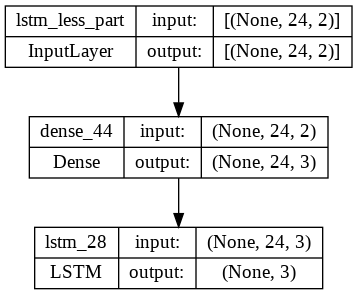

In [ ]:
## 這格是用來把模型畫出來
tf.keras.utils.plot_model(lstm_less_model , to_file='model.png', show_shapes=True)
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
for example_inputs, example_labels in wide_window_train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Labels shape (batch, time, features): (32, 24, 1)


In [ ]:
wide_window.example[0].shape

TensorShape([32, 24, 2])

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Simple experiment with Residual LSTM" \
  --description "Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Nv0YtyXkSn2skBMo6tmGLg/

[2022-12-01T12:10:02] Started scanning logdir.
[2022-12-01T12:10:07] Total uploaded: 150 scalars, 161 tensors (107.7 kB), 5 binary objects (858.1 kB)
[2022-12-01T12:10:07] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Nv0YtyXkSn2skBMo6tmGLg/


In [ ]:
# You must replace YOUR_EXPERIMENT_ID with the value output from the previous
# tensorboard `list` command or `upload` command.  For example
# `tensorboard dev delete --experiment_id pQpJNh00RG2Lf1zOe9BrQA`

!tensorboard dev delete --experiment_id HwLSxohMT8uEDkX7DtN4VQ

Deleted experiment HwLSxohMT8uEDkX7DtN4VQ.


In [ ]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


### Performance

With this dataset typically each of the models does slightly better than the one before it:

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [中+亞, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

ValueError: ignored

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 44.6541
Linear      : 69.6756
Dense       : 55.1409
Multi step dense: 57.4174
Conv        : 46.9838


# 2022-10-24 從這裡再往下修改

### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df[0], val_df=val_df[0], test_df=test_df[0])

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],label_columns=['中+亞'])

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Labels shape (batch, time, features): (32, 24, 1)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window_val)
performance['Baseline'] = baseline.evaluate(wide_window_test, verbose=0)

138/138 [==============================] - 1s 2ms/step - loss: 67116.3828 - mean_absolute_error: 156.7240


#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window, train=all_train, val=all_val)

# IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(all_val)
performance['Dense'] = dense.evaluate(all_test, verbose=0)

Epoch 1/20
501/501 [==============================] - 3s 4ms/step - loss: 3122847.7500 - mean_absolute_error: 490.9820 - val_loss: 11213.5996 - val_mean_absolute_error: 75.0977
Epoch 2/20
501/501 [==============================] - 2s 4ms/step - loss: 13119.7891 - mean_absolute_error: 76.0572 - val_loss: 9056.3252 - val_mean_absolute_error: 66.2293
Epoch 3/20
501/501 [==============================] - 2s 4ms/step - loss: 11207.8574 - mean_absolute_error: 70.5470 - val_loss: 7348.3936 - val_mean_absolute_error: 59.7646
Epoch 4/20
501/501 [==============================] - 2s 4ms/step - loss: 9003.8242 - mean_absolute_error: 62.9096 - val_loss: 5926.8970 - val_mean_absolute_error: 55.7377
Epoch 5/20
501/501 [==============================] - 2s 4ms/step - loss: 6512.5229 - mean_absolute_error: 53.0814 - val_loss: 4163.8188 - val_mean_absolute_error: 46.3009
Epoch 6/20
501/501 [==============================] - 2s 4ms/step - loss: 5428.3311 - mean_absolute_error: 48.4422 - val_loss: 3562.1

#### RNN


In [ ]:
%%time
# wide_window = WindowGenerator(
#     input_width=24, label_width=24, shift=1,
#     train_df=train_df[0], val_df=val_df[0], test_df=test_df[0]
#     )

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(3, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window, train=wide_window_train, val=wide_window_val)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window_val)
performance['LSTM'] = lstm_model.evaluate( wide_window_test, verbose=0)


Epoch 1/20
973/973 [==============================] - 8s 6ms/step - loss: 271749664.0000 - mean_absolute_error: 16319.6367 - val_loss: 282193024.0000 - val_mean_absolute_error: 16609.0059
Epoch 2/20
973/973 [==============================] - 6s 7ms/step - loss: 271694304.0000 - mean_absolute_error: 16317.9297 - val_loss: 282136736.0000 - val_mean_absolute_error: 16607.3145
Epoch 3/20
973/973 [==============================] - 6s 7ms/step - loss: 271639008.0000 - mean_absolute_error: 16316.2461 - val_loss: 282080544.0000 - val_mean_absolute_error: 16605.6172
Epoch 4/20
973/973 [==============================] - 6s 6ms/step - loss: 271583360.0000 - mean_absolute_error: 16314.5498 - val_loss: 282023936.0000 - val_mean_absolute_error: 16603.9160
Epoch 5/20
973/973 [==============================] - 5s 5ms/step - loss: 271527936.0000 - mean_absolute_error: 16312.8379 - val_loss: 281967808.0000 - val_mean_absolute_error: 16602.2266
Epoch 6/20
973/973 [==============================] - 5s 5ms

In [ ]:
for layer in lstm_model.layers:
  if isinstance(layer, layers.LSTM):
    print(layer, "weight:", layer.weights)
    print(layer, "bias:", layer.bias)
    print(layer, "bias_initilizer:", layer.bias_initializer)

<keras.layers.rnn.lstm.LSTM object at 0x7f6b3b541640> weight: [<tf.Variable 'lstm_30/lstm_cell_30/kernel:0' shape=(2, 12) dtype=float32, numpy=
array([[ 0.252334  ,  0.574332  ,  0.5305855 ,  0.5323492 , -0.01441509,
         0.31581366,  0.07705122,  0.32621163, -0.379678  , -0.20340553,
        -0.45954245,  0.31474727],
       [-0.48521197,  0.4042833 ,  0.00170583, -0.5075432 ,  0.43348444,
        -0.47137672,  0.35840452, -0.0883767 ,  0.3189401 ,  0.48294067,
        -0.23391154,  0.23014963]], dtype=float32)>, <tf.Variable 'lstm_30/lstm_cell_30/recurrent_kernel:0' shape=(3, 12) dtype=float32, numpy=
array([[ 0.23843622, -0.00959154, -0.26706195,  0.33524802, -0.5509774 ,
         0.41815323,  0.16327804, -0.07315356,  0.03566973, -0.49292922,
        -0.02390805, -0.06387705],
       [ 0.31277236,  0.39249617,  0.32528755,  0.32001534, -0.12893741,
         0.05467731,  0.24148919,  0.14425805, -0.43404877,  0.39005792,
        -0.25225496,  0.19230306],
       [ 0.37514812, -0

AttributeError: ignored

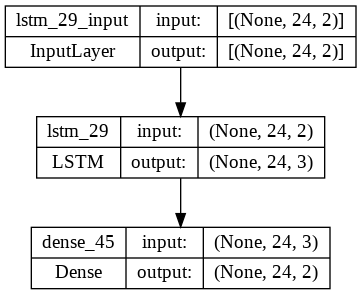

In [ ]:
## 這格是用來把模型畫出來
tf.keras.utils.plot_model(lstm_model , to_file='model.png', show_shapes=True)
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__() # 繼承的第一步得先實體化出來
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta # 一般只會輸出delta,這裡輸出inputs其實就是達到residual的功能，如果要堆疊多個residual的話，就是用多個ResidualWrapper(一個LSTM層)去堆疊

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def res_LSTM_model():
    model_input = layers.Input(shape=(24, 2))  ## 不用把batch那個axis給放進去，他會自己補None
    LSTM_1_output = layers.LSTM(32, return_sequences=True)(model_input)
    LSTM_2_output = layers.LSTM(32, return_sequences=True)(LSTM_1_output)
    x = layers.add([LSTM_1_output, LSTM_2_output])
    LSTM_3_output = layers.LSTM(32)(x)
    x = layers.add([x, LSTM_3_output])
    x = layers.Dense(16,activation='relu')(x)
    model_output = layers.Dense(3,activation='softmax')(x)
    
    return Model(model_input ,model_output)

In [ ]:
res_LSTM_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 24, 2)]      0           []                               
                                                                                                  
 lstm_14 (LSTM)                 (None, 24, 32)       4480        ['input_10[0][0]']               
                                                                                                  
 lstm_15 (LSTM)                 (None, 24, 32)       8320        ['lstm_14[0][0]']                
                                                                                                  
 add_3 (Add)                    (None, 24, 32)       0           ['lstm_14[0][0]',                
                                                                  'lstm_15[0][0]']          

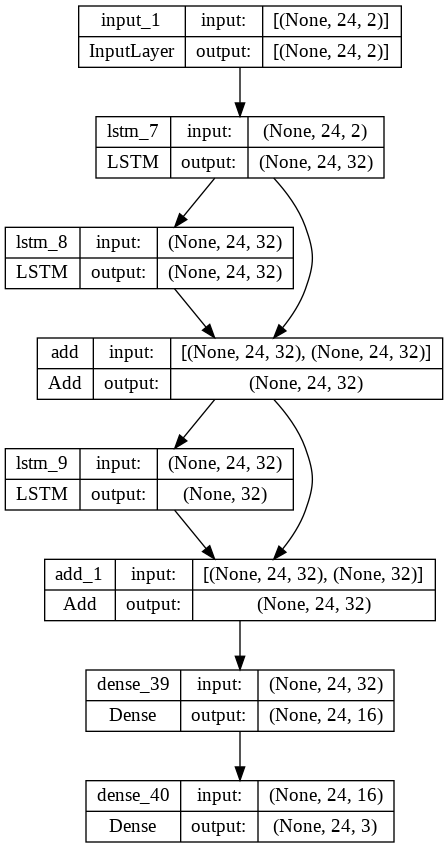

In [ ]:
## 這格是用來把模型畫出來
tf.keras.utils.plot_model(res_LSTM_model() , to_file='model.png', show_shapes=True)
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
## 把剛剛用funtional api建出來的模型train看看

history = compile_and_fit(res_LSTM_model(), wide_window, train=wide_window_train, val=wide_window_val, patience=5)

# IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window_val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window_test, verbose=0)
print()

Epoch 1/20
973/973 [==============================] - 18s 12ms/step - loss: 16319.9521 - mean_absolute_error: 16319.9609 - val_loss: 16610.1797 - val_mean_absolute_error: 16610.1758
Epoch 2/20
973/973 [==============================] - 10s 10ms/step - loss: 16319.9512 - mean_absolute_error: 16319.9570 - val_loss: 16610.1758 - val_mean_absolute_error: 16610.1719
Epoch 3/20
973/973 [==============================] - 10s 10ms/step - loss: 16319.9531 - mean_absolute_error: 16319.9658 - val_loss: 16610.1777 - val_mean_absolute_error: 16610.1797
Epoch 4/20
973/973 [==============================] - 10s 10ms/step - loss: 16319.9473 - mean_absolute_error: 16319.9717 - val_loss: 16610.1758 - val_mean_absolute_error: 16610.1738
Epoch 5/20
973/973 [==============================] - 10s 10ms/step - loss: 16319.9531 - mean_absolute_error: 16319.9609 - val_loss: 16610.1777 - val_mean_absolute_error: 16610.1797
Epoch 6/20
973/973 [==============================] - 10s 10ms/step - loss: 16319.9453 - m

KeyboardInterrupt: ignored

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())       
]))

# history = compile_and_fit(residual_lstm, wide_window, train=wide_window_train, val=wide_window_val, patience=5)

# # IPython.display.clear_output()
# val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window_val)
# performance['Residual LSTM'] = residual_lstm.evaluate(wide_window_test, verbose=0)
# print()

CPU times: user 17.7 ms, sys: 956 µs, total: 18.6 ms
Wall time: 39.3 ms


In [ ]:
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp

In [ ]:
## 這邊下次來要改
residual_lstm.compile(
    optimizer='adam',
    loss='MeanSquaredError',
    metrics=['MeanAbsoluteError'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 512,
    'dropout': 0.2
})

residual_lstm.fit(
    wide_window_train, 
    epochs=5, 
    validation_data=wide_window_val, 
    callbacks=[tensorboard_callback, hparams_callback])

AttributeError: ignored

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Simple experiment with Residual LSTM" \
  --description "Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/giVZYaEzSBG26qn3kZLedQ/

[2022-11-23T11:22:23] Started scanning logdir.
[2022-11-23T11:22:31] Total uploaded: 120 scalars, 138 tensors (93.4 kB), 4 binary objects (1.1 MB)
[2022-11-23T11:22:31] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/giVZYaEzSBG26qn3kZLedQ/


In [ ]:
# You must replace YOUR_EXPERIMENT_ID with the value output from the previous
# tensorboard `list` command or `upload` command.  For example
# `tensorboard dev delete --experiment_id pQpJNh00RG2Lf1zOe9BrQA`

!tensorboard dev delete --experiment_id x9h7DSvyRvm5MgU34mgRNg

Deleted experiment x9h7DSvyRvm5MgU34mgRNg.


#### Performance

Here is the overall performance for these multi-output models.

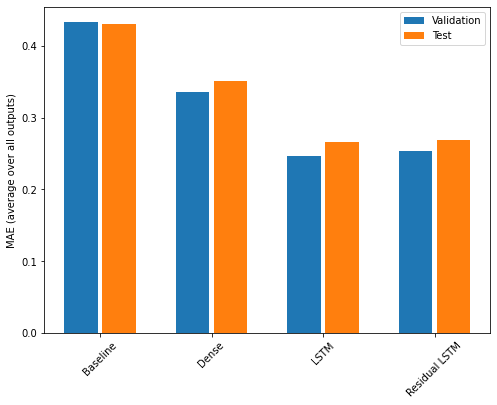

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.4303
Dense          : 0.3509
LSTM           : 0.2664
Residual LSTM  : 0.2693


The above performances are averaged across all model outputs.

# 2022/11/02 做到這裏，下次從這裡往下改

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


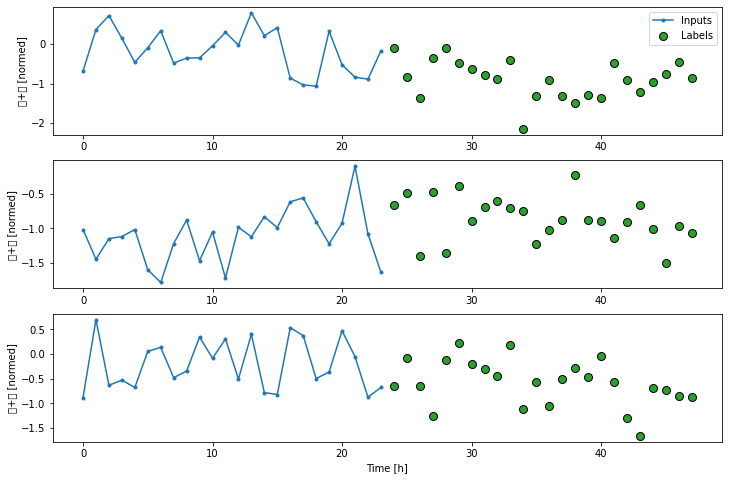

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               train_df=train_df[0], val_df=val_df[0], test_df=test_df[0],
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Labels shape (batch, time, features): (32, 24, 2)


In [ ]:
## multi_window資料集合併
OUT_STEPS = 24
multi_window_train = None
multi_window_val = None
multi_window_test = None
for i in range(len(train_df)):

  multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               train_df=train_df[i], val_df=val_df[i], test_df=test_df[i],
                               label_columns=['中+亞'],
                               shift=OUT_STEPS) 

  if i == 0:
    multi_window_train = multi_window.train
    multi_window_val = multi_window.val
    multi_window_test = multi_window.test
  else:
    multi_window_train = multi_window_train.concatenate(multi_window.train)
    multi_window_val = multi_window_val.concatenate(multi_window.val)
    multi_window_test = multi_window_test.concatenate(multi_window.test)

multi_window_train = multi_window_train.cache().shuffle(10000)
multi_window_val = multi_window_val.cache().shuffle(10000)
multi_window_test = multi_window_test.cache().shuffle(10000)


### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

62/62 [==============================] - 0s 2ms/step - loss: 194820.7656 - mean_absolute_error: 329.6550


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


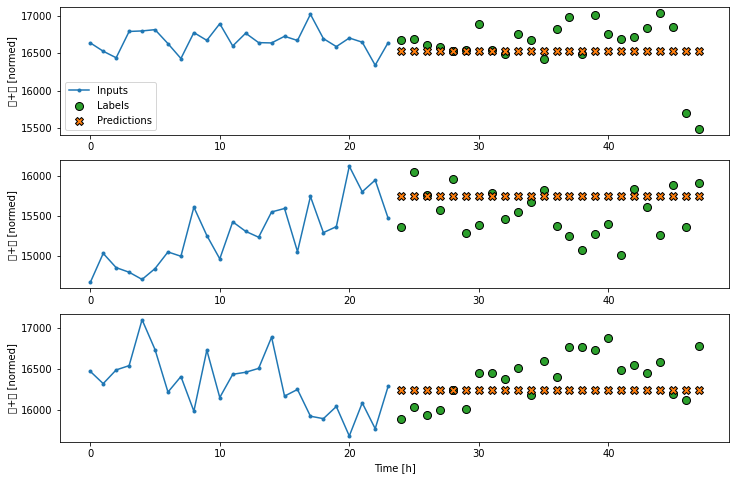

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1]) # 複製所有batch的最後一筆的所有feature的資料，batch、feature都只乘以1次，但time乘以OUT_STEPS次

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])


multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window_val)
multi_performance['Last'] = last_baseline.evaluate(multi_window_test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

62/62 [==============================] - 0s 2ms/step - loss: 287317.7812 - mean_absolute_error: 408.2466


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


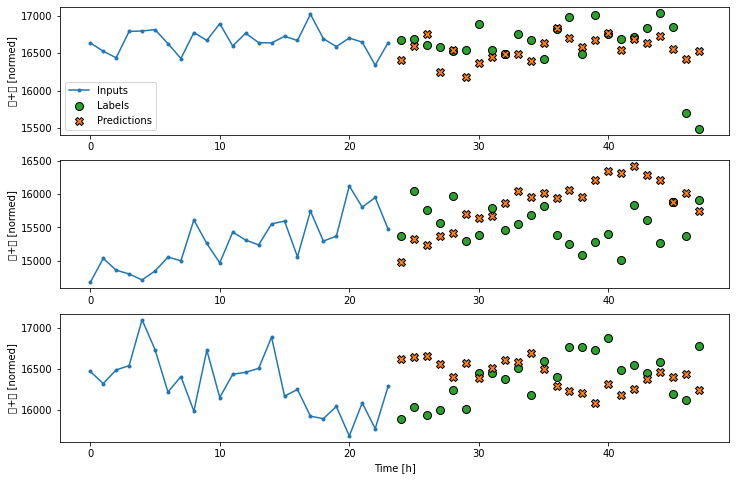

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window_val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window_test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

Epoch 1/20
233/233 [==============================] - 2s 4ms/step - loss: 163239552.0000 - mean_absolute_error: 12489.7842 - val_loss: 95640080.0000 - val_mean_absolute_error: 9747.5742
Epoch 2/20
233/233 [==============================] - 1s 3ms/step - loss: 51612932.0000 - mean_absolute_error: 6953.9482 - val_loss: 25092574.0000 - val_mean_absolute_error: 4985.0332
Epoch 3/20
233/233 [==============================] - 1s 3ms/step - loss: 12049443.0000 - mean_absolute_error: 3316.2422 - val_loss: 4597235.5000 - val_mean_absolute_error: 2109.5862
Epoch 4/20
233/233 [==============================] - 1s 3ms/step - loss: 2070733.8750 - mean_absolute_error: 1310.8788 - val_loss: 651742.8125 - val_mean_absolute_error: 735.7162
Epoch 5/20
233/233 [==============================] - 1s 3ms/step - loss: 395444.5625 - mean_absolute_error: 500.1929 - val_loss: 171414.8750 - val_mean_absolute_error: 321.5075
Epoch 6/20
233/233 [==============================] - 1s 3ms/step - loss: 215047.4844 - m

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


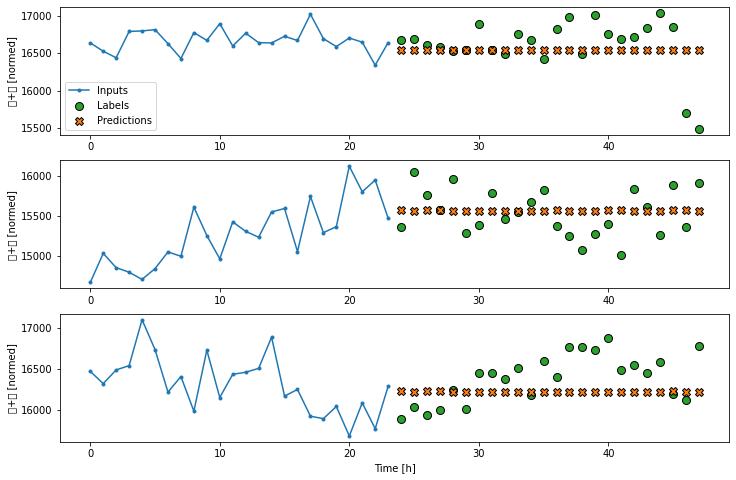

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), # 把指抓最後一個time的運算，弄成一個layer的方式，output出來的結果就是，每個batch的每個feature的最後一個time的資料
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) # 再把輸出結果reshape
])

history = compile_and_fit(multi_linear_model, multi_window, train=multi_window_train, val=multi_window_val, patience=5)

# IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window_val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window_test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

Epoch 1/20
233/233 [==============================] - 1s 4ms/step - loss: 14848510.0000 - mean_absolute_error: 1648.8641 - val_loss: 144557.0781 - val_mean_absolute_error: 279.5188
Epoch 2/20
233/233 [==============================] - 1s 3ms/step - loss: 204791.1562 - mean_absolute_error: 314.7592 - val_loss: 143804.4844 - val_mean_absolute_error: 278.8752
Epoch 3/20
233/233 [==============================] - 1s 3ms/step - loss: 204342.6406 - mean_absolute_error: 314.6219 - val_loss: 142967.9688 - val_mean_absolute_error: 279.6383
Epoch 4/20
233/233 [==============================] - 1s 4ms/step - loss: 204959.7500 - mean_absolute_error: 315.0544 - val_loss: 144338.9844 - val_mean_absolute_error: 281.6264
Epoch 5/20
233/233 [==============================] - 1s 4ms/step - loss: 205993.5625 - mean_absolute_error: 316.1888 - val_loss: 146519.8750 - val_mean_absolute_error: 282.1261
Epoch 6/20
233/233 [==============================] - 1s 3ms/step - loss: 205049.0625 - mean_absolute_error

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


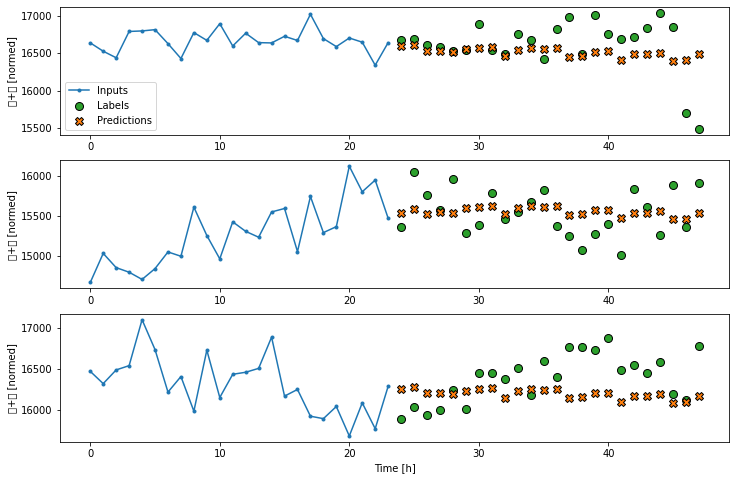

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window, train=multi_window_train, val=multi_window_val, patience=5)

# IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window_val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window_test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

Epoch 1/20
233/233 [==============================] - 2s 7ms/step - loss: 17525096.0000 - mean_absolute_error: 1758.5759 - val_loss: 137206.2500 - val_mean_absolute_error: 270.8485
Epoch 2/20
233/233 [==============================] - 1s 6ms/step - loss: 197538.0469 - mean_absolute_error: 308.2162 - val_loss: 137083.1875 - val_mean_absolute_error: 271.0415
Epoch 3/20
233/233 [==============================] - 1s 4ms/step - loss: 198103.0156 - mean_absolute_error: 309.3269 - val_loss: 139822.3750 - val_mean_absolute_error: 277.6473
Epoch 4/20
233/233 [==============================] - 1s 4ms/step - loss: 198527.7812 - mean_absolute_error: 309.7611 - val_loss: 138674.5625 - val_mean_absolute_error: 272.4213
Epoch 5/20
233/233 [==============================] - 1s 3ms/step - loss: 200058.5938 - mean_absolute_error: 312.6507 - val_loss: 144028.0781 - val_mean_absolute_error: 279.8165
Epoch 6/20
233/233 [==============================] - 1s 4ms/step - loss: 199650.0938 - mean_absolute_error

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


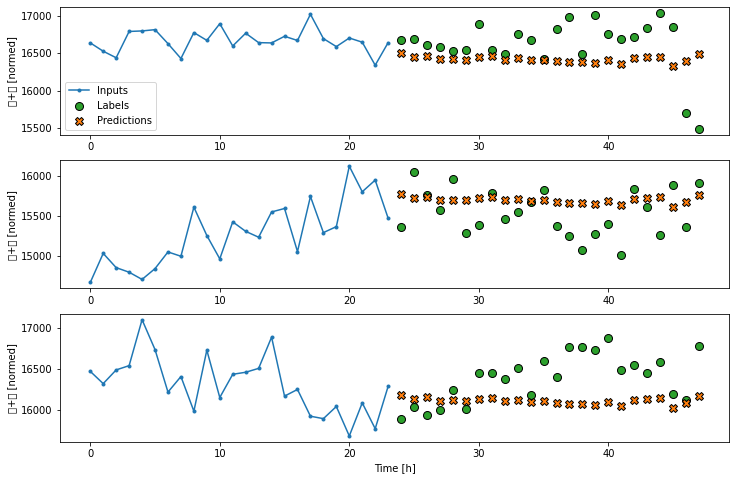

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window, train=multi_window_train, val=multi_window_val, patience=5)

# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window_val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window_test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


Epoch 1/20
233/233 [==============================] - 3s 7ms/step - loss: 258842752.0000 - mean_absolute_error: 15889.4219 - val_loss: 274809408.0000 - val_mean_absolute_error: 16527.3945
Epoch 2/20
233/233 [==============================] - 1s 5ms/step - loss: 258804880.0000 - mean_absolute_error: 15888.2432 - val_loss: 274770560.0000 - val_mean_absolute_error: 16526.2188
Epoch 3/20
233/233 [==============================] - 1s 5ms/step - loss: 258767888.0000 - mean_absolute_error: 15887.0762 - val_loss: 274732160.0000 - val_mean_absolute_error: 16525.0527
Epoch 4/20
233/233 [==============================] - 1s 5ms/step - loss: 258731184.0000 - mean_absolute_error: 15885.9131 - val_loss: 274693888.0000 - val_mean_absolute_error: 16523.8984
Epoch 5/20
233/233 [==============================] - 1s 5ms/step - loss: 258694464.0000 - mean_absolute_error: 15884.7607 - val_loss: 274655648.0000 - val_mean_absolute_error: 16522.7441
Epoch 6/20
233/233 [==============================] - 1s 5ms

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


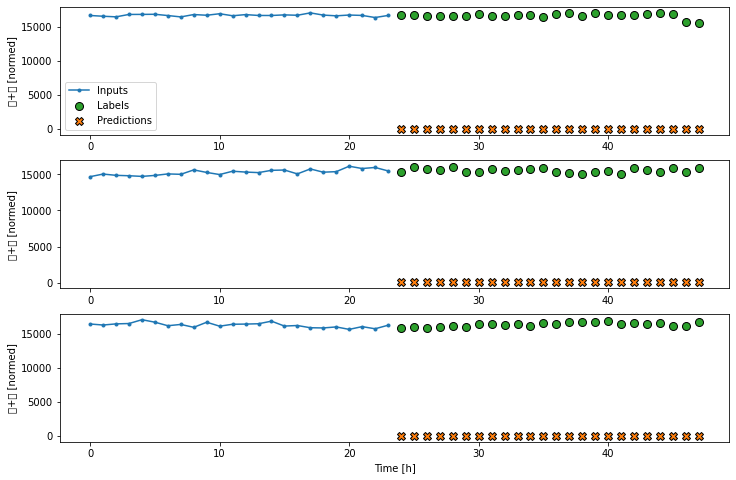

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, train=multi_window_train, val=multi_window_val, patience=5)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction) ## 先把第一次LSTMCell的輸出結果丟進去prediction中

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps): ## 看你要輸出幾步，就跑幾次LSTMCell迴圈，如此就會有幾個output
    # Use the last prediction as input.  ## 把上一部預測出來的結果當成這次LSTMCell的input，如此就可以達到autoregressive的效果
    x = prediction
    # Execute one lstm step. 
    x, state = self.lstm_cell(x, states=state,    ## 每多一步的預測，就多跑一次LSTMCell
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 2)


Now, train the model:

Epoch 1/20
233/233 [==============================] - 16s 50ms/step - loss: 258596336.0000 - mean_absolute_error: 15881.6992 - val_loss: 274406400.0000 - val_mean_absolute_error: 16515.1992
Epoch 2/20
233/233 [==============================] - 11s 47ms/step - loss: 258302960.0000 - mean_absolute_error: 15872.4590 - val_loss: 274133952.0000 - val_mean_absolute_error: 16506.9473
Epoch 3/20
233/233 [==============================] - 11s 47ms/step - loss: 258046672.0000 - mean_absolute_error: 15864.4023 - val_loss: 273870336.0000 - val_mean_absolute_error: 16498.9609
Epoch 4/20
233/233 [==============================] - 11s 47ms/step - loss: 257796896.0000 - mean_absolute_error: 15856.4814 - val_loss: 273612448.0000 - val_mean_absolute_error: 16491.1406
Epoch 5/20
233/233 [==============================] - 11s 46ms/step - loss: 257550880.0000 - mean_absolute_error: 15848.7295 - val_loss: 273357952.0000 - val_mean_absolute_error: 16483.4258
Epoch 6/20
233/233 [==============================

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


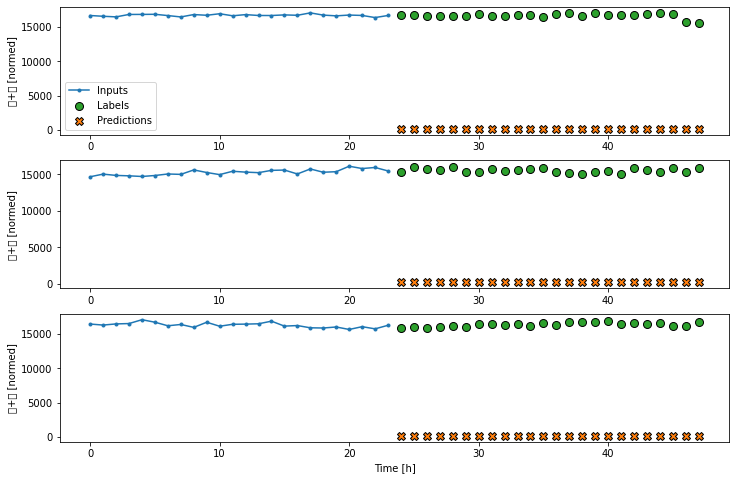

In [ ]:
history = compile_and_fit(feedback_model, multi_window, train=multi_window_train, val=multi_window_val, patience=5)

# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window_val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window_test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

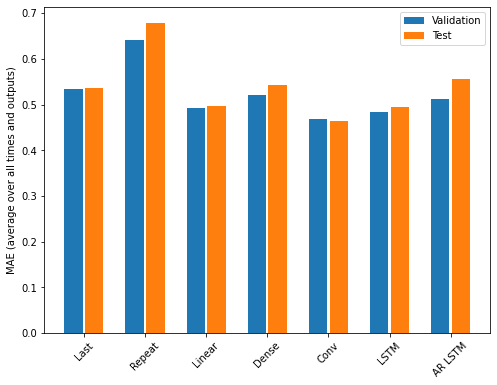

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2980
Dense   : 0.2778
Conv    : 0.2725
LSTM    : 0.2743
AR LSTM : 0.2876


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.


#後續修改窗格製作方式，為測試不把自己納為feature之一看看結果

In [ ]:
features_considered = ['FI-254-1.PV', '中+亞']

In [ ]:
all_df[1]

,FI-254-1.PV.1,中+亞.1
1,17780.84180,16314.05950
2,17766.41992,16312.07048
3,17925.15430,16372.45377
4,17880.90430,16654.40028
5,17701.00391,16775.89931
...,...,...
1434,16904.88281,15622.67625
1435,17103.28125,15734.93567
1436,17175.98047,15545.50041
1437,17157.21680,15570.28269


In [ ]:
len(all_df[1])

1438

In [ ]:
## 正規化 normalize MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

## 把每組資料及正規化後放進list中，待會要轉成dataset
datasets = []
for i in range(len(all_df)):
  dataset = all_df[i].values
  dataset = min_max_scaler.fit_transform(dataset)
  dataset = pd.DataFrame(dataset)
  dataset.columns = ["FI-254-1.PV","中+亞"]
  datasets += [dataset]

print(len(datasets))
print(datasets[1])

10
      FI-254-1.PV       中+亞
0        0.659602  0.429033
1        0.655189  0.428397
2        0.703758  0.447725
3        0.690219  0.537973
4        0.635173  0.576864
...           ...       ...
1433     0.391578  0.207728
1434     0.452284  0.243661
1435     0.474528  0.183025
1436     0.468787  0.190958
1437     0.485125  0.210194

[1438 rows x 2 columns]


In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size, # 這裡的dataset記得要轉成ndarray才行
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size # start_index是指窗格中feature的最後一筆資料的位置，所以是歷史資料加上一開始要shift start_index格
  if end_index is None: # end_index就是窗格要做到最後哪一個index，如果設定為None就做到最後
    end_index = len(dataset) - target_size # 最後一個窗格的座標，因為要往後預測target_size筆資料，所以要往前退target_size筆資料

  for i in range(start_index, end_index): # 一個一個座標抓出來做成一個窗格，從start_index到end_index
    indices = range(i-history_size, i, step) # step是指多少筆資料抽一筆出來，可能用來縮小資料量
    if len(dataset.shape) == 1: # 如果feature只有一個，要幫他補feature那個維度，不然會少一個維度
      data.append(np.reshape(dataset[indices], (history_size, 1)))
    else:
      data.append(dataset[indices]) # 把dataset參數中的資料帶進來，一次抓indices大小，放進list中一個元素就是一個窗格

    if single_step:
      labels.append(target[i+target_size]) # 如果設定single_step，那label就會是feature的最後一個座標，再加上target_size，的那一個值
    else:
      labels.append(target[i:i+target_size]) # 如果沒設定single_step，那label就會是feature的最後一個座標，到target_size這個座標之間的那一群值，一次預測多筆數值

  return np.array(data), np.array(labels)

In [ ]:
## 這格不走正規化，下格走
past_history = 40
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(all_df[0]["FI-254-1.PV"].values, 
                                                   all_df[0]["中+亞"].values, 
                                                   0, # index=1是FI-254-1，index=2是中+亞
                                                   int(len(all_df[0])*0.7), past_history, # 1000筆前為訓練集，後為驗證集
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(all_df[0]["FI-254-1.PV"].values, all_df[0]["中+亞"].values,
                                               int(len(all_df[0])*0.7), int(len(all_df[0])*0.9), past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
## 這格走正規化，所以all_df[0]改為dataset
past_history = 40
future_target = 1
STEP = 1

train_single = []
val_single = []
test_single = []

for i in range(len(datasets)):
  x_train_single, y_train_single = multivariate_data(datasets[i]["FI-254-1.PV"].values, 
                                                   datasets[i]["中+亞"].values, 
                                                   0, # index=1是FI-254-1，index=2是中+亞
                                                   int(len(all_df[0])*0.7), past_history, # 1000筆前為訓練集，後為驗證集
                                                   future_target, STEP,
                                                   single_step=True)
  x_val_single, y_val_single = multivariate_data(datasets[i]["FI-254-1.PV"].values, datasets[i]["中+亞"].values,
                                               int(len(all_df[0])*0.7), int(len(all_df[0])*0.9), past_history,
                                               future_target, STEP,
                                               single_step=True)
  x_test_single, y_test_single = multivariate_data(datasets[i]["FI-254-1.PV"].values, datasets[i]["中+亞"].values,
                                               int(len(all_df[0])*0.9), None, past_history,
                                               future_target, STEP,
                                               single_step=True)
  
  train_single += [(x_train_single, y_train_single)]
  val_single += [(x_val_single, y_val_single)]
  test_single += [(x_test_single, y_test_single)]

print("len(train_single):", len(train_single))
print("len(val_single):", len(val_single))
print("len(test_single):", len(test_single))

len(train_single): 10
len(val_single): 10
len(test_single): 10


In [ ]:
#@title 因為有很多組資料，所以做成Dataset後全部串起來，然後打亂
BATCH_SIZE = 256
BUFFER_SIZE = 10000

## 執行前先reset一下
train_data = None
val_data = None
test_data = None

for i in range(len(train_single)):
  train_data_single = tf.data.Dataset.from_tensor_slices((train_single[i]))
  train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_data_single = tf.data.Dataset.from_tensor_slices((val_single[i]))
  val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

  test_data_single = tf.data.Dataset.from_tensor_slices((test_single[i]))
  test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

  if i == 0:
    train_data = train_data_single
    val_data = val_data_single
    test_data = test_data_single
  else:
    train_data = train_data.concatenate(train_data_single)
    val_data = val_data.concatenate(val_data_single)
    test_data = test_data.concatenate(test_data_single)

## 窗格都做好了，所以再來打亂應該是可以的
train_data = train_data.cache().shuffle(10000)
val_data = val_data.cache().shuffle(10000)
test_data = test_data.cache().shuffle(10000)


In [ ]:
x_train_single.shape[-2:]

(40, 1)

In [ ]:
#@title LSTM model
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:],
                                           return_sequences=False)                                           
)

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
#@title Conv1d model
## 不需要使用Flatten，所以也不用Reshape去把time的dimension弄出來
single_step_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    # tf.keras.layers.Conv1D(filters=32,
    #                        kernel_size=(3,), # 沒辦法在加層是因為上一層的conv1D出來後timestamp就只剩1了，如此kernel_size只要開大於1都會超過窗格，會跳錯誤
    #                        activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
#@title 把KerasTuner安裝上
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 25.2 MB/s 
     |████████████████████████████████| 1.6 MB 56.9 MB/s 


In [ ]:
#@title 用API的方式來構件模型使用KerasTuner容易些
from tensorflow import keras
from tensorflow.keras import layers

def conv1d_model(hp):
    filters = hp.Int(name="filters", min_value=16, max_value=64, step=16) # 搜索空間最小16最大64，一步64
    kernel_size = hp.Int(name="kernel_size", min_value=3, max_value=9, step=2) # 搜索空間最小16最大64，一步64
    model = keras.Sequential([
        layers.Conv1D(filters,
                           kernel_size,
                           activation='relu'),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"]) # "rmsprop", "adam"選用試試看，超參數也可以不同類型：Int、Float、Boolean 或 Choice
    model.compile(
        optimizer=optimizer,
        loss="mae",
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

In [ ]:
#@title Tuner用BayesianOptimization優化器，其實就是搜索空間中來跑迴圈的概念
import kerastuner as kt
tuner = kt.BayesianOptimization( ## 內建的優化器有RandomSearch、BayesianOptimization、Hyperband
    conv1d_model, # 這裡要改成剛剛構建的模型
    objective="val_loss", # 要優化的指標
    max_trials=100, # 結束搜索前不同模型試驗的最大次數
    executions_per_trial=2, # 為了減小方差，可以對多次訓練同一個模型的結果取平均，executions_per_trial是對每種模型的配置試驗的訓練次數，這裡是2就可以做2次取平均
    directory="mnist_kt_test", # 儲存的資料夾名稱
    overwrite=True, # 重新開始tune的時候是否要覆蓋前一筆結果，如果有修改模型這裡就要True，如果是做到一半，可能要做很久，這裡要接著上次的結果，就要設定False
)

In [ ]:
#@title 看看Tuner的搜索空間
tuner.search_space_summary()

Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 9, 'step': 2, 'sampling': None}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


In [ ]:
#@title Start to search
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
tuner.search(
    train_data,
    steps_per_epoch=500, # train我改用無限循環的dataset，所以這裡要設定
    batch_size=128,
    epochs=100, # 這邊設大一點，靠earlystopping來停
    validation_data=val_data,
    validation_steps=50, # val我改用無限循環的dataset，所以這裡要設定
    callbacks=callbacks,
    verbose=1,
)

# single_step_history = single_step_model.fit(train_data, epochs=EPOCHS,
#                                             steps_per_epoch=EVALUATION_INTERVAL,
#                                             validation_data=val_data,
#                                             validation_steps=50)

Trial 8 Complete [00h 01m 30s]
val_loss: 0.06927909329533577

Best val_loss So Far: 0.06927909329533577
Total elapsed time: 00h 11m 38s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
48                |48                |filters
7                 |7                 |kernel_size
rmsprop           |rmsprop           |optimizer

Epoch 1/100
500/500 [==============================] - 8s 10ms/step - loss: 0.1347 - mean_absolute_percentage_error: 536532.7500 - mean_absolute_error: 0.1347 - val_loss: 0.0695 - val_mean_absolute_percentage_error: 16.5689 - val_mean_absolute_error: 0.0695
Epoch 2/100
500/500 [==============================] - 5s 10ms/step - loss: 0.1269 - mean_absolute_percentage_error: 551002.2500 - mean_absolute_error: 0.1269 - val_loss: 0.0704 - val_mean_absolute_percentage_error: 16.9786 - val_mean_absolute_error: 0.0704
Epoch 3/100
290/500 [================>.............] - ETA: 1s - loss: 0.1272 - mean_absolute_percentage_error: 457329.5312

KeyboardInterrupt: ignored

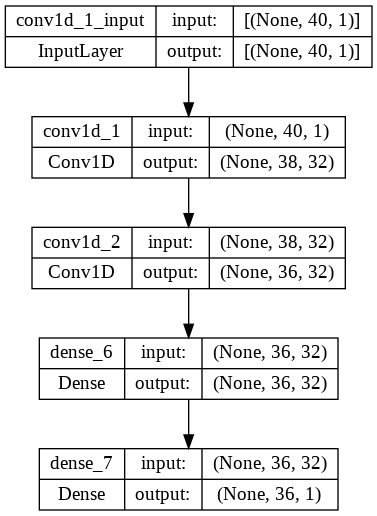

In [ ]:
#@title 畫出model架構
tf.keras.utils.plot_model(single_step_model, "single_step_model_with_shape_info.png", show_shapes=True)

In [ ]:
for x, y in test_data.take(1):
  print(single_step_model.predict(x).shape)

4/4 [==============================] - 0s 13ms/step
(103, 36, 1)


In [ ]:
#@title trainning
EVALUATION_INTERVAL = 1000
EPOCHS = 10

single_step_history = single_step_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=50)

Epoch 1/10
1000/1000 [==============================] - 12s 8ms/step - loss: 0.1317 - mean_absolute_percentage_error: 465871.7812 - mean_absolute_error: 0.1317 - val_loss: 0.0744 - val_mean_absolute_percentage_error: 18.3063 - val_mean_absolute_error: 0.0744
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1270 - mean_absolute_percentage_error: 499636.8750 - mean_absolute_error: 0.1270 - val_loss: 0.0761 - val_mean_absolute_percentage_error: 18.7988 - val_mean_absolute_error: 0.0761
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1270 - mean_absolute_percentage_error: 601461.0000 - mean_absolute_error: 0.1270 - val_loss: 0.0716 - val_mean_absolute_percentage_error: 17.4132 - val_mean_absolute_error: 0.0716
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1269 - mean_absolute_percentage_error: 522137.8438 - mean_absolute_error: 0.1269 - val_loss: 0.0742 - val_mean_absolute_percentage_error: 18.2386 -

In [ ]:
test_predict = single_step_model.predict(x)

4/4 [==============================] - 0s 3ms/step


In [ ]:
#@title 隨機取1000筆測試集中的資料來看看結果
teat_performance = single_step_model.evaluate(test_data, verbose=1, steps=1000) # 因為test_data是無限循環的dataset所以必須設定steps，要告訴他跑幾組資料後停下來

1000/1000 [==============================] - 5s 3ms/step - loss: 0.0813 - mean_absolute_percentage_error: 13.2032 - mean_absolute_error: 0.0813


In [ ]:
print(test_predict)
print(test_predict.shape)

[[0.48251686]
 [0.4974245 ]
 [0.49457732]
 [0.48060146]
 [0.4719126 ]
 [0.47709534]
 [0.47775948]
 [0.4877749 ]
 [0.49413505]
 [0.5038947 ]
 [0.50604045]
 [0.5022241 ]
 [0.47511926]
 [0.45012626]
 [0.43876463]
 [0.40377975]
 [0.38315958]
 [0.3812539 ]
 [0.3712026 ]
 [0.33526656]
 [0.32805985]
 [0.38042837]
 [0.51469433]
 [0.64676476]
 [0.7020689 ]
 [0.69294614]
 [0.6912836 ]
 [0.68579847]
 [0.65723443]
 [0.6429729 ]
 [0.64317226]
 [0.63922906]
 [0.6413047 ]
 [0.6442129 ]
 [0.654491  ]
 [0.65073   ]
 [0.65474725]
 [0.66589653]
 [0.6614725 ]
 [0.66670555]
 [0.6724892 ]
 [0.65958977]
 [0.6537167 ]
 [0.6415029 ]
 [0.63907516]
 [0.6420969 ]
 [0.6732516 ]
 [0.67676234]
 [0.6758455 ]
 [0.67723835]
 [0.6832091 ]
 [0.68479204]
 [0.70244193]
 [0.71853524]
 [0.7031686 ]
 [0.709403  ]
 [0.714861  ]
 [0.7040712 ]
 [0.687169  ]
 [0.68836606]
 [0.6813    ]
 [0.66222996]
 [0.65422595]
 [0.64577234]
 [0.65096825]
 [0.68913704]
 [0.74887866]
 [0.7791016 ]
 [0.7930645 ]
 [0.79722375]
 [0.78489393]
 [0.76

In [ ]:
y

<tf.Tensor: shape=(103,), dtype=float64, numpy=
array([0.48770066, 0.48231847, 0.46267735, 0.47114593, 0.46144469,
       0.45964718, 0.55266023, 0.55828848, 0.56380604, 0.5445344 ,
       0.55769409, 0.55002495, 0.58073896, 0.59836119, 0.52965422,
       0.54402943, 0.54167497, 0.53361224, 0.54713632, 0.5476634 ,
       0.58049913, 0.62171754, 0.6160098 , 0.59490399, 0.66262264,
       0.62362814, 0.59141452, 0.63642067, 0.63972303, 0.61143192,
       0.57981261, 0.56493145, 0.61011695, 0.58244056, 0.58989359,
       0.67603878, 0.64483424, 0.67519249, 0.67602327, 0.62135363,
       0.6383093 , 0.64490226, 0.64973374, 0.60107818, 0.63616131,
       0.60289171, 0.57069053, 0.58043339, 0.61212948, 0.64123829,
       0.6437888 , 0.69586152, 0.6736107 , 0.68032696, 0.66764694,
       0.64833467, 0.58438955, 0.62214381, 0.61146861, 0.58758894,
       0.55463488, 0.55283355, 0.56475584, 0.60408884, 0.64116551,
       0.64240876, 0.68347794, 0.66798033, 0.63595205, 0.63403292,
       0.64033

In [ ]:
df = {"label": np.array(y),
     "predict" : val_predict.reshape(-1,)}
df = pd.DataFrame(df)

In [ ]:
mydir = './'
csv_file = os.path.join(mydir, "df.csv")
df.to_csv(csv_file, index=False)

# 這裡往下是整理後的程式碼


In [1]:
#@title Import 函式庫

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### 資料放在google drive上，資料不是完全連續的，是一段一段的

In [2]:
from google.colab import drive
root = '/content/drive/'
drive.mount(root)

Mounted at /content/drive/


In [3]:
## 這是抓1min資料
# pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/林園管歷史資料擷取.csv",encoding="ANSI")
pipe3 = pd.read_csv("/content/drive/My Drive/Side project/Leak detection/pipe3_1min.csv",encoding="utf-8")
pipe3 = pipe3.drop(0) # 去除missing data
# pipe3 = pipe3.drop("Unnamed: 113", axis = 1)
print(pipe3.shape)
# pipe3.head()
pipe3.describe(include = "all").transpose()

(5758, 49)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,1438,1438,2021/8/18 00:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLY_USI_03_FI_BC,1438.0,NaN,NaN,NaN,-0.509961,3.137588,-17.292027,-2.232041,-0.536289,1.19465,9.198226
FI-254-1.PV,1438.0,NaN,NaN,NaN,17377.760536,338.95963,16427.69727,17147.87061,17392.725585,17620.897458,18170.12109
中+亞,1438.0,NaN,NaN,NaN,17203.901275,553.288104,15179.77192,16843.921632,17190.811735,17517.38474,19082.95748
Unnamed: 4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time.1,1438,1438,2021/8/23 00:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLY_USI_03_FI_BC.1,1438.0,NaN,NaN,NaN,-0.517134,3.371431,-13.779897,-2.200337,-0.417813,1.37214,8.572825
FI-254-1.PV.1,1438.0,NaN,NaN,NaN,17036.86773,417.739119,15625.12109,16787.727055,17039.353515,17256.411135,18893.33594
中+亞.1,1438.0,NaN,NaN,NaN,16860.113144,451.902991,14973.70915,16609.52143,16883.32139,17124.97213,18097.82534
Unnamed: 9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['Time', 'CLY_USI_03_FI_BC', 'FI-254-1.PV', '中+亞'], dtype='object')
Index(['CLY_USI_03_FI_BC', 'FI-254-1.PV', '中+亞'], dtype='object')
(1434, 3)
(1434, 3)
(1434, 3)
(1434, 3)
(5754, 3)
(5754, 3)
(5754, 3)
(5754, 3)
(5754, 3)
(5754, 3)
(5754, 3)
(5754, 3)
(1434, 3)
(1434, 3)
(5754, 3)
(5754, 3)
(5690, 3)
(5690, 3)
(5754, 3)
(5754, 3)


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0, flags=flags)


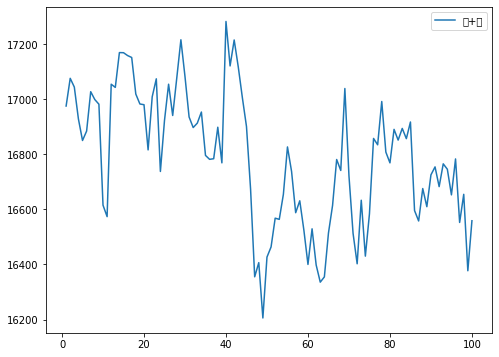

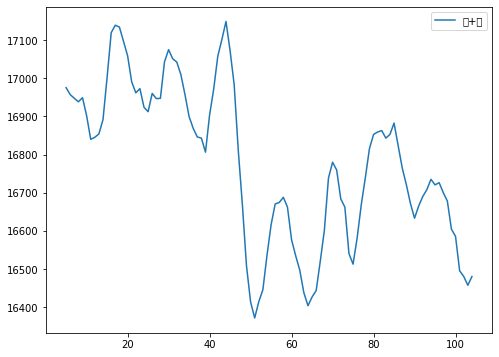

In [28]:
## 這邊是抓1min資料用的
#先把全部資料一組一組放進list中
all_df = [pipe3.iloc[:,0:4].copy(), pipe3.iloc[:,5:9].copy(), pipe3.iloc[:,10:14].copy(), pipe3.iloc[:,15:19].copy(), pipe3.iloc[:,20:24].copy(), 
          pipe3.iloc[:,25:29].copy(),pipe3.iloc[:,30:34].copy(),pipe3.iloc[:,35:39].copy(),pipe3.iloc[:,40:44].copy(),pipe3.iloc[:,45:49].copy(),]

do_norm = False ## False表示沒做正規化，用於後面要做inverse_transform時判斷用

for i, part_df in enumerate(all_df):
  part_df = part_df.dropna() # 去除missing data

  if i == 0:
    part_df[[part_df.columns[3],]].head(100).plot() ## 把沒移動平均的值畫出來
    print(part_df.columns)

  part_df = part_df.rolling(5).mean() ## 做移動平均，rolling(n)，做n筆移動平均，如果不做移動平均，n可以設定為1
  part_df = part_df.dropna()  ## 做完移動平均後，前n個值因為沒辦法做移動平均，所以要drop掉，如果不做移動平均，把這行跟上面那行一起mark掉
  
  if i == 0:
    part_df[[part_df.columns[2],]].head(100).plot() ## 把移動平均後的值畫出來比較看看
    print(part_df.columns) ## 印出來比較一下，發現time的column不見了

  all_df[i] = part_df
  
  ## 下面兩行是印出來確認，是不是真的有放進去，如果形狀一樣表示成功
  print(part_df.shape)
  print(all_df[i].shape)


In [29]:
#@title 特徵工程，把資料集裡面原本5個特徵，只抽出來源端與接收端流量，其他可能干擾先拿掉
for i in range(len(all_df)):
  all_df[i] = all_df[i].iloc[:,1:3]
  print(all_df[i].shape)
  print(all_df[i].columns)

(1434, 2)
Index(['FI-254-1.PV', '中+亞'], dtype='object')
(1434, 2)
Index(['FI-254-1.PV.1', '中+亞.1'], dtype='object')
(5754, 2)
Index(['FI-254-1.PV.2', '中+亞.2'], dtype='object')
(5754, 2)
Index(['FI-254-1.PV.3', '中+亞.3'], dtype='object')
(5754, 2)
Index(['FI-254-1.PV.4', '中+亞.4'], dtype='object')
(5754, 2)
Index(['FI-254-1.PV.5', '中+亞.5'], dtype='object')
(1434, 2)
Index(['FI-254-1.PV.6', '中+亞.6'], dtype='object')
(5754, 2)
Index(['FI-254-1.PV.7', '中+亞.7'], dtype='object')
(5690, 2)
Index(['FI-254-1.PV.8', '中+亞.8'], dtype='object')
(5754, 2)
Index(['FI-254-1.PV.9', '中+亞.9'], dtype='object')


In [30]:
## 把column name都改成跟第0組一樣，方便等等把切分成windows後的資料串接起來
for i in range(len(all_df)):
  all_df[i].columns = all_df[0].columns
  # train_df[i].columns = train_df[0].columns
  # val_df[i].columns = val_df[0].columns
  # test_df[i].columns = test_df[0].columns
  print(f"\n第{i+1}組column name")
  print("data columns: ", all_df[i].columns)
  # print("train data columns: ", train_df[i].columns)
  # print("val  data columns: ", val_df[i].columns)
  # print("test data columns: ", val_df[i].columns)


第1組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第2組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第3組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第4組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第5組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第6組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第7組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第8組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第9組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')

第10組column name
data columns:  Index(['FI-254-1.PV', '中+亞'], dtype='object')


In [31]:
#@title Feature Scaling，做minmaxscaler正規化

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

## 把每組資料及正規化後放進list中，待會要轉成dataset
datasets = []
for i in range(len(all_df)):
  dataset = all_df[i].values
  dataset = min_max_scaler.fit_transform(dataset)
  dataset = pd.DataFrame(dataset)
  dataset.columns = ["FI-254-1.PV","中+亞"]
  datasets += [dataset]

print(len(datasets))
print(datasets[1])

10
      FI-254-1.PV       中+亞
0        0.685705  0.482299
1        0.669753  0.517443
2        0.639195  0.558838
3        0.590079  0.596214
4        0.546259  0.620756
...           ...       ...
1429     0.350990  0.219969
1430     0.375341  0.231353
1431     0.407375  0.208235
1432     0.427740  0.191053
1433     0.450759  0.177215

[1434 rows x 2 columns]


In [8]:
#@title 多變數ndarray轉成feature,label的tuple，方便等等用來做windows

def multivariate_data(dataset, target, start_index, end_index, history_size, # 這裡的dataset記得要轉成ndarray才行
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size # start_index是指窗格中feature的最後一筆資料的位置，所以是歷史資料加上一開始要shift start_index格
  if end_index is None: # end_index就是窗格要做到最後哪一個index，如果設定為None就做到最後
    end_index = len(dataset) - target_size # 最後一個窗格的座標，因為要往後預測target_size筆資料，所以要往前退target_size筆資料

  for i in range(start_index, end_index): # 一個一個座標抓出來做成一個窗格，從start_index到end_index
    indices = range(i-history_size, i, step) # step是指多少筆資料抽一筆出來，可能用來縮小資料量
    if len(dataset.shape) == 1: # 如果feature只有一個，要幫他補feature那個維度，不然會少一個維度
      data.append(np.reshape(dataset[indices], (history_size, 1)))
    else:
      data.append(dataset[indices]) # 把dataset參數中的資料帶進來，一次抓indices大小，放進list中一個元素就是一個窗格

    if single_step:
      labels.append(target[i+target_size]) # 如果設定single_step，那label就會是feature的最後一個座標，再加上target_size，的那一個值
    else:
      labels.append(target[i:i+target_size]) # 如果沒設定single_step，那label就會是feature的最後一個座標，到target_size這個座標之間的那一群值，一次預測多筆數值

  return np.array(data), np.array(labels)

In [32]:
#@title 把資料分為train, val, test三組，拆分比例為(70%,20%,10%)，並分別放入list中
past_history = 40 # 設定取過去幾筆資料做成窗格
future_target = 1 # 幾個target
STEP = 1  # 看取出來的資料中，要間隔多少取一筆資料出來，可用來縮小資料量

train_single = []
val_single = []
test_single = []

for i in range(len(datasets)):
  x_train_single, y_train_single = multivariate_data(datasets[i]["FI-254-1.PV"].values, 
                                                   datasets[i]["中+亞"].values, 
                                                   0, # index=1是FI-254-1，index=2是中+亞
                                                   int(len(all_df[0])*0.7), past_history, # 1000筆前為訓練集，後為驗證集
                                                   future_target, STEP,
                                                   single_step=True)
  x_val_single, y_val_single = multivariate_data(datasets[i]["FI-254-1.PV"].values, datasets[i]["中+亞"].values,
                                               int(len(all_df[0])*0.7), int(len(all_df[0])*0.9), past_history,
                                               future_target, STEP,
                                               single_step=True)
  x_test_single, y_test_single = multivariate_data(datasets[i]["FI-254-1.PV"].values, datasets[i]["中+亞"].values,
                                               int(len(all_df[0])*0.9), None, past_history,
                                               future_target, STEP,
                                               single_step=True)
  
  train_single += [(x_train_single, y_train_single)]
  val_single += [(x_val_single, y_val_single)]
  test_single += [(x_test_single, y_test_single)]

# 確認list中是否有10組資料
print("len(train_single):", len(train_single)) 
print("len(val_single):", len(val_single))
print("len(test_single):", len(test_single))

len(train_single): 10
len(val_single): 10
len(test_single): 10


In [33]:
#@title 做成Dataset後全部串起來，窗格也做好了所以10組資料打亂訓練可能效果比較均勻
BATCH_SIZE = 256
BUFFER_SIZE = 10000 ## 可以設定大一點，我希望全部資料都打亂

## 執行前先reset一下
train_data = None
val_data = None
test_data = None

for i in range(len(train_single)):
  train_data_single = tf.data.Dataset.from_tensor_slices((train_single[i]))
  train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_data_single = tf.data.Dataset.from_tensor_slices((val_single[i]))
  val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

  test_data_single = tf.data.Dataset.from_tensor_slices((test_single[i]))
  test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

  if i == 0:
    train_data = train_data_single
    val_data = val_data_single
    test_data = test_data_single
  else:
    train_data = train_data.concatenate(train_data_single)
    val_data = val_data.concatenate(val_data_single)
    test_data = test_data.concatenate(test_data_single)

## 窗格都做好了，所以再來打亂應該是可以的
train_data = train_data.cache().shuffle(10000)
val_data = val_data.cache().shuffle(10000)
test_data = test_data.cache().shuffle(10000)


In [ ]:
#@title LSTM model，跟下面那格選一個執行，如果要用keras tuner就不用執行
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:],
                                           return_sequences=False)                                           
)

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
#@title Conv1d model，跟上面那格選一個執行，如果要用keras tuner就不用執行
## 不需要使用Flatten，所以也不用Reshape去把time的dimension弄出來
single_step_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    # tf.keras.layers.Conv1D(filters=32,
    #                        kernel_size=(3,), # 沒辦法在加層是因為上一層的conv1D出來後timestamp就只剩1了，如此kernel_size只要開大於1都會超過窗格，會跳錯誤
    #                        activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])

In [11]:
#@title 把KerasTuner安裝上
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.4 MB/s eta 0:00:00


In [39]:
#@title 用API的方式來構建模型使用KerasTuner
from tensorflow import keras
from tensorflow.keras import layers

def conv1d_model(hp):
    filters = hp.Int(name="filters", min_value=16, max_value=64, step=16) # 搜索空間最小16最大64，一步16
    # kernel_size = hp.Int(name="kernel_size", min_value=3, max_value=9, step=2) # 搜索空間最小3最大9，一步2
    model = keras.Sequential([
        layers.Conv1D(filters,
                           #kernel_size,
                            kernel_size=5,
                           activation='relu'),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"]) # "rmsprop", "adam"選用試試看，超參數也可以不同類型：Int、Float、Boolean 或 Choice
    model.compile(
        optimizer=optimizer,
        loss="mae",
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

In [40]:
#@title Tuner用BayesianOptimization優化器，其實就是搜索空間中來跑迴圈的概念
import kerastuner as kt
tuner = kt.BayesianOptimization( ## 內建的優化器有RandomSearch、BayesianOptimization、Hyperband
    conv1d_model, # 這裡要改成剛剛構建的模型
    objective="val_loss", # 要優化的指標
    max_trials=10, # 結束搜索前不同模型試驗的最大次數
    executions_per_trial=2, # 為了減小方差，可以對多次訓練同一個模型的結果取平均，executions_per_trial是對每種模型的配置試驗的訓練次數，這裡是2就可以做2次取平均
    directory="conv1d_model_kt_test", # 儲存的資料夾名稱
    overwrite=True, # 重新開始tune的時候是否要覆蓋前一筆結果，如果有修改模型這裡就要True，如果是做到一半，可能要做很久，這裡要接著上次的結果，就要設定False
)

In [41]:
#@title 看看Tuner的搜索空間
tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


In [42]:
#@title Start to search
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
tuner.search(
    train_data,
    steps_per_epoch=500, # train我改用無限循環的dataset，所以這裡要設定
    batch_size=128,
    epochs=100, # 這邊設大一點，靠earlystopping來停
    validation_data=val_data,
    validation_steps=50, # val我改用無限循環的dataset，所以這裡要設定
    callbacks=callbacks,
    verbose=1,
)

# single_step_history = single_step_model.fit(train_data, epochs=EPOCHS,
#                                             steps_per_epoch=EVALUATION_INTERVAL,
#                                             validation_data=val_data,
#                                             validation_steps=50)

Trial 10 Complete [00h 01m 19s]
val_loss: 0.07003041356801987

Best val_loss So Far: 0.07003041356801987
Total elapsed time: 00h 17m 24s


In [43]:
top_n = 2
best_hps = tuner.get_best_hyperparameters(top_n) #返回一个由 HyperParameter 对象组成的列表，你可以将其传递给模型构建函数

In [44]:
print(best_hps)

[<keras_tuner.engine.hyperparameters.HyperParameters object at 0x7fa5be05ee80>, <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7fa53c1364c0>]


In [47]:
train_full = train_data.concatenate(val_data)
train_full.cache().shuffle(10000)

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 40, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [48]:
#@title 找出最好的epochs，因為前面search時可能次數太少，未overfitting
def get_best_epoch(hp):
    model = conv1d_model(hp)    
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)]# 使用較大的patience                       
    history = model.fit(train_data, validation_data=val_data, epochs=100, batch_size=128,
                        steps_per_epoch=500, # train我改用無限循環的dataset，所以這裡要設定
                        validation_steps=50, # val我改用無限循環的dataset，所以這裡要設定
                        callbacks=callbacks)    
    val_loss_per_epoch= history.history["val_loss"]    
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1    
    print(f"Best epoch: {best_epoch}")    
    return best_epoch

In [49]:
#@title 
def get_best_trained_model(hp):
    best_epoch = get_best_epoch(hp)
    model = conv1d_model(hp)
    model.fit(train_full, batch_size=128, 
              steps_per_epoch=500, # train我改用無限循環的dataset，所以這裡要設定
              epochs=int(best_epoch * 1.2)) ## 書中因為訓練及變大了所以把epochs調大，我這邊沒變所以不用調   
              # epochs=int(best_epoch))
    return model
best_models = []
for hp in best_hps: # 前面取了前4名好的超參數出來，所以應該會整個執行4輪
  model = get_best_trained_model(hp)    
  model.evaluate(test_data, verbose=1, steps=1000)  ## 因為dataset會重複循環，所以取1000次來看看  
  best_models.append(model)

Epoch 1/100
500/500 [==============================] - 8s 10ms/step - loss: 0.1419 - mean_absolute_percentage_error: 490111.9688 - mean_absolute_error: 0.1419 - val_loss: 0.0726 - val_mean_absolute_percentage_error: 17.2444 - val_mean_absolute_error: 0.0726
Epoch 2/100
500/500 [==============================] - 6s 13ms/step - loss: 0.1352 - mean_absolute_percentage_error: 556816.5625 - mean_absolute_error: 0.1352 - val_loss: 0.0701 - val_mean_absolute_percentage_error: 16.2653 - val_mean_absolute_error: 0.0701
Epoch 3/100
500/500 [==============================] - 5s 10ms/step - loss: 0.1350 - mean_absolute_percentage_error: 553397.5625 - mean_absolute_error: 0.1350 - val_loss: 0.0710 - val_mean_absolute_percentage_error: 16.6677 - val_mean_absolute_error: 0.0710
Epoch 4/100
500/500 [==============================] - 5s 10ms/step - loss: 0.1344 - mean_absolute_percentage_error: 574626.5000 - mean_absolute_error: 0.1344 - val_loss: 0.0791 - val_mean_absolute_percentage_error: 19.1843 - 

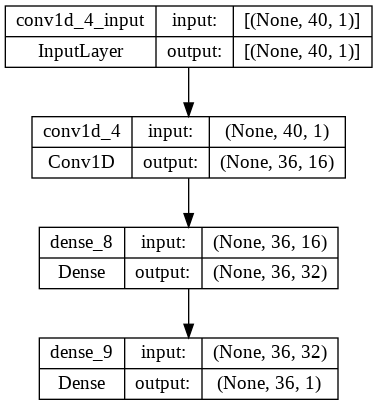

In [51]:
#@title 畫出model架構
tf.keras.utils.plot_model(model, "conv1d_model_with_shape_info.png", show_shapes=True)

In [53]:
## 拿一筆出來看看形狀
for x, y in test_data.take(1):
  print(model.predict(x).shape)

4/4 [==============================] - 0s 12ms/step
(103, 36, 1)
